# Binary Similarity Notebooks

Nomenclature: BinSim_Datasets,variety number_filtering (multiple if multiple datasets with different filters are being used)

Variety number only used for grapevine Datasets. This nomenclature doesn't have 'Analysis' between BinSim and Datasets as it is a secondary notebook to those that have 

In this case, BinSim_GD11_all6_all13.ipynb

Peak Filtering and Alignments explained after imports


# Warning - 14 Grapevine Varieties

This notebook analysis the Grapevine Datasets with 14 different varieties in alignments.h5 or alignments_old.h5.

Furthermore, it performs the same analysis as BinSim_Analysis_GD11_all2_groups2all1.ipynb with a different filtering and alignment, however it is less well organized and commented than that notebook. 

So, it is recommended to see the other notebooks.

## Organization of the Notebook

- Imports and Presentation of the Grapevine datasets filtering/alignments analysed in this notebook
- Reading the two filtering/alignments (Negative and Positive grapevine datasets for each alignment)
- Performing the different pre-treatments (including BinSim) on the datasets
- Preliminary analysis on the 1st alignment set of datasets
- Agglomerative Hierarchical Clustering and K-means Clustering
- Random Forest - optimization, predictive accuracy and important features
- PLS-DA - optimization, predictive accuracy and important features
- Permutation Tests

### Needed Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns
import itertools

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf
from metabolinks.similarity import mz_similarity

# Python files in the repository
import scaling as sca
import multianalysis as ma

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib inline

# Similarity analysis with BinSim and different combinations of traditional pre-treatments - Grapevine Dataset with 14 Grapevine varieties

## Peak Alignment and Peak Filtering was performed with an in-house Python script available in the metabolinks package (see peak_alignments.ipynb notebook)

### 1st Filtering/Alignment: Feature present in at least 6 samples in the dataset - min_sample = 6 with all samples of the dataset - Name: all6 or 1-6

### 2nd Filtering/Alignment: Feature present in at least 13 samples in the dataset - min_sample = 13 with all samples of the dataset - NAME: all13 or 1-13

To better understand the functions used outside of normal Python packages, see scaling.py and multianalysis.py where they are better described.

#### Extra CHT, CFN and SB samples.

## Similarity analysis

Grapevine Datasets have a total of 42 samples and 14 biological groups - grapevine varieties (3 samples per group).

Negative Grapevine Dataset = Negative GD or NGD

Positive Grapevine Dataset = Positive GD or PGD

Binary Similarity = BinSim

#### Datasets

aligned_all_neg = Negative GD alignment 1-6 / bin_neg - binary matrix equivalent

aligned_all_pos = Positive GD alignment 1-6 / bin_pos - binary matrix equivalent

aligned_all_neg2 = Negative GD alignment 1-13 / bin_neg2 - binary matrix equivalent

aligned_all_pos2 = Positive GD alignment 1-13 / bin_pos2 - binary matrix equivalent

### Read aligned data of the 1st Alignment 1-6

In [3]:
aligned_all_pos = pd.HDFStore('alignments.h5').get('all_1ppm_min6_pos')
aligned_all_neg = pd.HDFStore('alignments.h5').get('all_1ppm_min6_neg')

In [4]:
#def read_aligned_files(filename):
#    """Short function to read the aligned files fast while putting the MultiIndex in the correct order for the CDL accessor."""
#    df = pd.read_csv(filename, header = None, index_col = [0])
#    df.index.name = 'm/z'
#    mi = pd.concat([df.iloc[1, :],df.iloc[0, :]], axis = 'columns')
#    mi = pd.MultiIndex.from_frame(mi)
#    final_file = pd.read_csv(filename, header = [0,1], index_col = [0])
#    final_file.columns = mi
#    return final_file

In [5]:
#aligned_all_pos = read_aligned_files('aligned_1ppm_min1-6_1ppm_positive.csv')
#aligned_all_neg = read_aligned_files('aligned_1ppm_min1-6_1ppm_negative.csv')

### Read aligned data of the 2nd Alignment 1-13

In [6]:
# From the alignments_new store
aligned_all_pos2 = pd.HDFStore('alignments.h5').get('all_1ppm_min13_pos')
aligned_all_neg2 = pd.HDFStore('alignments.h5').get('all_1ppm_min13_neg')

### Global metadata for consistency between tables and plots

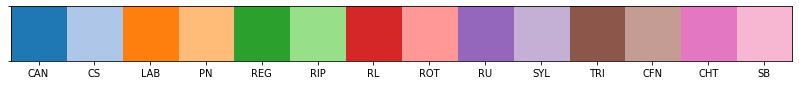

In [7]:
# Useful data
sample_names = aligned_all_neg.cdl.samples
all_labels = aligned_all_neg.cdl.labels
unique_labels = aligned_all_neg.cdl.unique_labels

# customize these colors
colours = sns.color_palette('tab20', 14)

label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

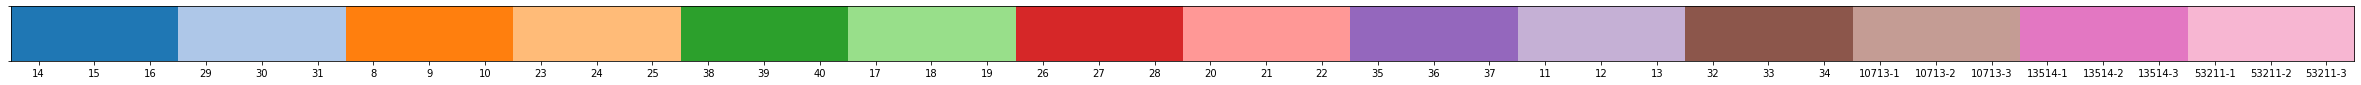

In [8]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

## Data transformations

### Each Dataset is transformed to binary or treated by a combination of more established treatments

### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Similarity

##### BinSim - `df_to_bool` function (very simple)

In [9]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)


def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    intensities = dataset
    dicto = {}
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store results
    dicto['binary'] = df_to_bool(intensities)
    dicto['Ionly'] = imputed
    dicto['P'] = P
    dicto['NP'] = NP
    dicto['NGP'] = NGP
    
    return dicto

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used for these datasets

[M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da

Search in the Negative GD and Positive GD for the reference feature with `search_for_ref_feat` (details in scaling.py).

### 1st Filtering/Alignment - 1-6

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature and apply the different treatments.

In [10]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg, 554.262022) # see if the function gives the reference feature
print(RefEst_Neg) # It did! (m/z peak, distance to theoretical mass)

# Theoretical mass for positive mode Leucine Enkephalin - 556.276575.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos, 556.276575)
print(RefEst_Pos)

(554.2620199999996, 2.0000004496978363e-06)
(556.2765711904766, 3.8095233776402893e-06)


In [11]:
# Negative mode dataset
treat_neg = compute_transf(aligned_all_neg, norm_ref = 554.2620199999996)

# Positive mode dataset
treat_pos = compute_transf(aligned_all_pos, norm_ref = 556.2765711904766)

### 2nd Filtering/Alignment - 1-13

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature and apply the different treatments.

In [12]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022.
RefEst_Neg = sca.search_for_ref_feat(aligned_all_neg2, 554.262022) # see if the function gives the reference feature
print(RefEst_Neg) # It did! (m/z peak, distance to theoretical mass)

# Theoretical mass for positive mode Leucine Enkephalin - 556.276575.
RefEst_Pos = sca.search_for_ref_feat(aligned_all_pos2, 556.276575)
print(RefEst_Pos)

(554.2620199999996, 2.0000004496978363e-06)
(556.2765711904766, 3.8095233776402893e-06)


In [13]:
# Negative mode dataset
treat_neg2 = compute_transf(aligned_all_neg2, norm_ref = 554.2620199999996)

# Positive mode dataset
treat_pos2 = compute_transf(aligned_all_pos2, norm_ref = 556.2765711904766)

In [14]:
#aligned_all_pos2 = read_aligned_files('aligned_1ppm_min1-13_1ppm_positive.csv')
#aligned_all_neg2 = read_aligned_files('aligned_1ppm_min1-13_1ppm_negative.csv')

## Preliminary Similiarity analysis on the 1st Alignment 

### Compute m/z similarities

In [15]:
sim_pos = mz_similarity(aligned_all_pos, has_labels = True)
sim_neg = mz_similarity(aligned_all_neg, has_labels = True)

In [16]:
print(sim_pos)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       339  198  179  187  203  173  195  176  186  151  ...  166       11   
15       198  470  199  259  259  251  226  223  224  206  ...  232       12   
16       179  199  366  211  207  210  193  200  192  170  ...  176       13   
29       187  259  211  636  328  362  226  240  234  285  ...  322       17   
30       203  259  207  328  612  318  232  241  249  279  ...  320       17   
31       173  251  210  362  318  626  219  234  234  269  ...  302       22   
8        195  226  193  226  232  219  433  231  219  185  ...  201       14   
9        176  223  200  240  241  234  231  446  245  202  ...  222       18   
10       186  224  192  234  249  234  219  245  470  199  ...  233       15   
23       151  206  170  285  279  269  185  202  199  723  ...  406       23   
24       152  196  167  280  268  267  193  197  202  481  ...  408       23 

In [17]:
print(sim_neg)


Sample similarity, counts of common peaks
          14   15   16   29   30   31    8    9   10   23  ...   34  10713-1  \
14       359  188  231  184  181  173  156  175  172   39  ...  150        8   
15       188  252  153  134  124  114  128  131  147   17  ...  154        6   
16       231  153  357  201  200  193  179  212  202   79  ...  144        6   
29       184  134  201  455  391  329  138  134  122   75  ...  232       18   
30       181  124  200  391  477  329  140  137  132   75  ...  257       24   
31       173  114  193  329  329  412  126  126  124   84  ...  180       19   
8        156  128  179  138  140  126  343  271  284   89  ...  132        5   
9        175  131  212  134  137  126  271  368  298   87  ...  138        5   
10       172  147  202  122  132  124  284  298  370   88  ...  140        4   
23        39   17   79   75   75   84   89   87   88  202  ...   20       12   
24        57   29   94   96   92  103  103   97  102  156  ...   30       12 

### Clustermap peak list function

In [18]:
def clustermap_peak_list(aligned):
    aligned_01 = aligned.copy()
    aligned_01[aligned_01.notnull()] = 1
    aligned_01[aligned_01.isnull()] = 0
    aligned_01.columns = aligned_01.cdl.samples

    ulabels = aligned.cdl.unique_labels
    n = len(ulabels)
    
    p = sns.color_palette() + sns.color_palette("Set1", n_colors=n-10, desat=.5)
    sample_to_labels = pd.Series(aligned.cdl.labels, index=aligned.cdl.samples)
    label_colors = pd.Series(p, index=ulabels)
    sample_colors = sample_to_labels.map(label_colors)
    
    g = sns.clustermap(aligned_01, metric="jaccard", figsize=(15, 20), 
                       row_cluster=False,
                       col_colors=sample_colors,
                       yticklabels=False)
    # fix bug in seaborn, error in clustermap if cbar == False
    ax=g.cax; aax=ax.clear(); aax = ax.axis('off'); 

    # draw legend
    lpatches = [mpatches.Patch(color=c, label=lbl) for (lbl, c) in label_colors.iteritems()]
    leg = plt.legend(handles=lpatches, fontsize=20)
    return g

Sample HC, NEGATIVE mode


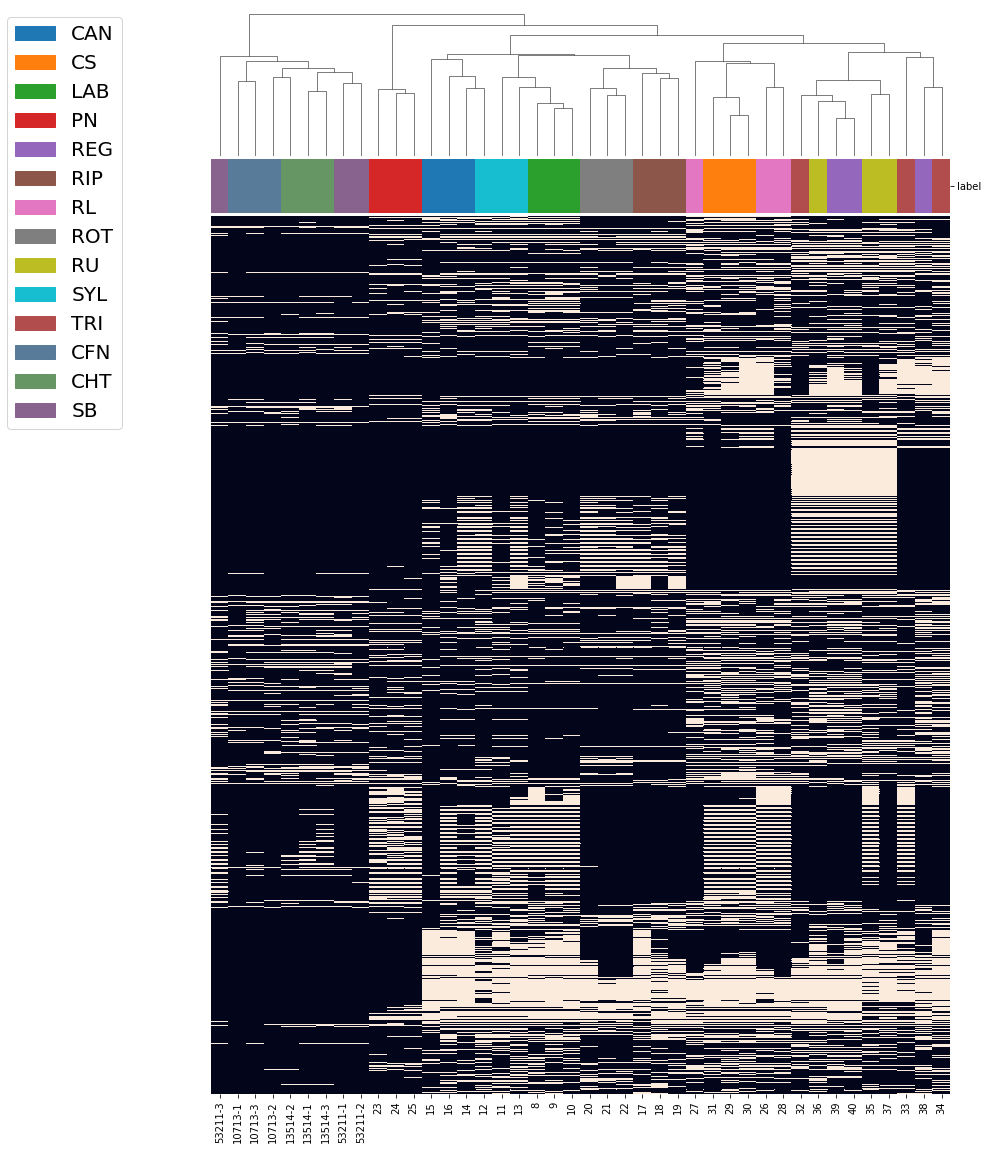

In [19]:
print('Sample HC, NEGATIVE mode')
g = clustermap_peak_list(aligned_all_neg)

Sample HC, POSITIVE mode


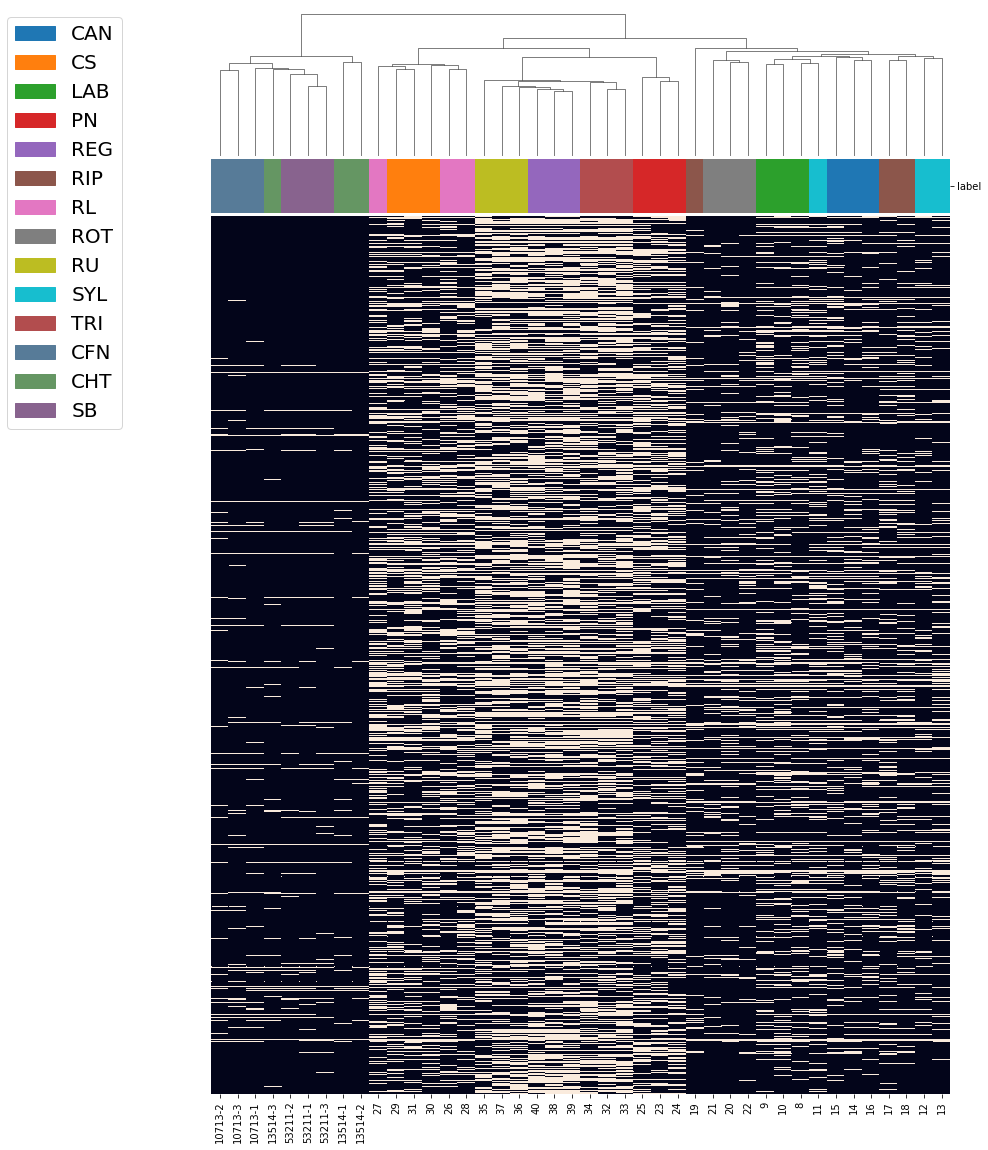

In [20]:
print('Sample HC, POSITIVE mode')
g = clustermap_peak_list(aligned_all_pos)

### Similarity analysis (Jaccard)

In [21]:
def plot_jaccard_sims(dataset, title=''):
    intensities = dataset
    sims = mz_similarity(intensities, has_labels=True)
    #grid_kws = {"height_ratios": (0.4, 0.4, 0.02)}
    f, ax = plt.subplots(1,2, figsize=(14, 7), constrained_layout=True) # gridspec_kw=grid_kws,

    hm = sns.heatmap(sims.sample_similarity_jaccard, annot=False, square=True, ax=ax[0], cmap='YlGnBu', cbar=None)
    hm = sns.heatmap(sims.label_similarity_jaccard, annot=True, square=True, ax=ax[1], cmap='YlGnBu')
    
    #Correction for heatmap bug in latest version of seaborn
    bottom, top = ax[0].get_ylim()
    ax[0].set_ylim(bottom + 0.5, top - 0.5)
    bottom, top = ax[1].get_ylim()
    ax[1].set_ylim(bottom + 0.5, top - 0.5)
    
    ax[0].set_title('Sample similarity')
    ax[1].set_title('Group similarity')
    f.suptitle(title, fontsize=16)

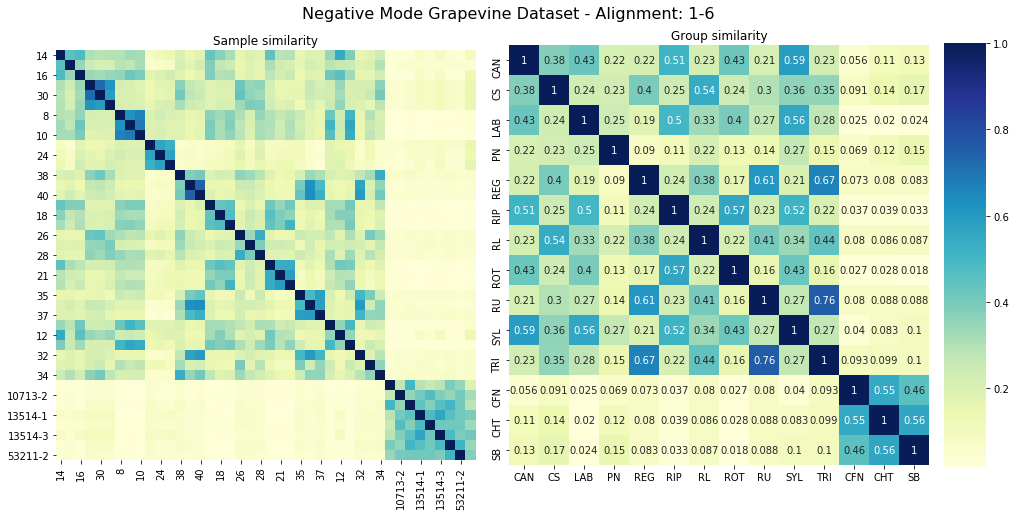

In [22]:
plot_jaccard_sims(aligned_all_neg, 'Negative Mode Grapevine Dataset - Alignment: 1-6')

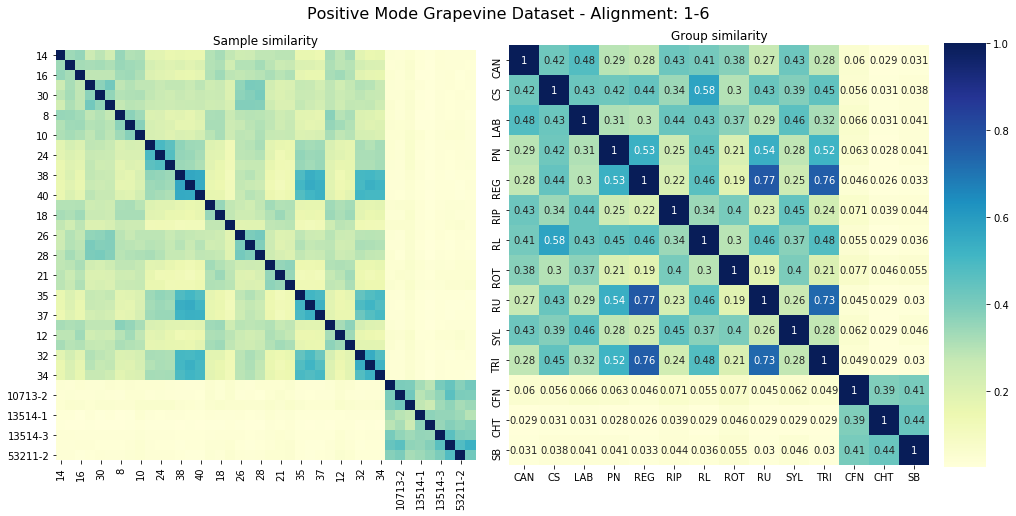

In [23]:
plot_jaccard_sims(aligned_all_pos, 'Positive Mode Grapevine Dataset - Alignment: 1-6')

#### Verification that `dist.pdist()` produces the same result as `mz_similarity()`

In [24]:
intensities = aligned_all_neg
neg_01 = treat_neg['binary']

scipy_jdist = dist.pdist(neg_01.T, metric='jaccard')
df_scipy_dist = pd.DataFrame(dist.squareform(scipy_jdist), index=sample_names, columns=sample_names)

#sim_neg = mz_similarity(intensities, has_labels=True)
jsim = sim_neg.sample_similarity_jaccard
jsim.index.name = 'Sample'
jsim.columns.name = 'Sample'
df_scipy_dist.index.name = 'Sample'
df_scipy_dist.columns.name = 'Sample'
jdist = 1 - jsim

from pandas.testing import assert_frame_equal
assert_frame_equal(jdist, df_scipy_dist)
# No exception should be raised!

Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-6 (cophenetic = 0.96261)


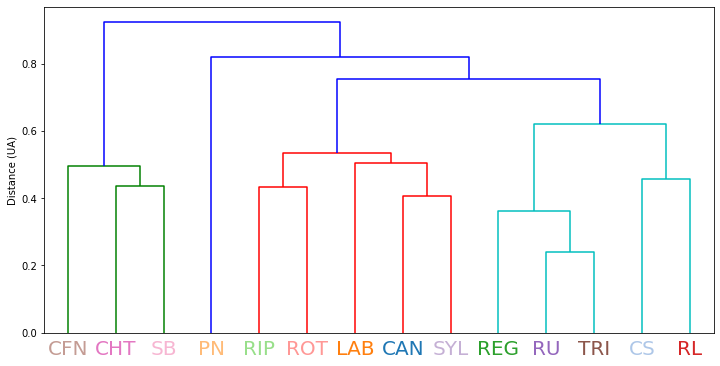

In [25]:
jdist = dist.squareform(1 - sim_neg.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Negative mode Grapevine dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-6 (cophenetic = 0.97734)


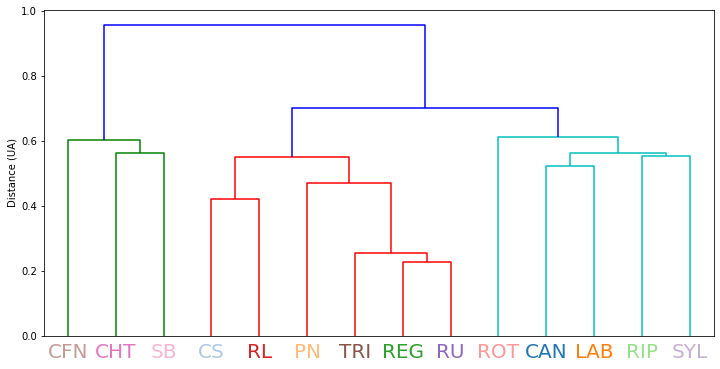

In [26]:
jdist = dist.squareform(1 - sim_pos.label_similarity_jaccard.values)
Z = hier.linkage(jdist, method='average')

coph = hier.cophenet(Z,jdist)[0]
print(f'Dendogram from Jaccard distance, Positive mode Grapevine dataset - Alignment: 1-6 (cophenetic = {coph:.5f})')

fig = plt.figure(figsize=(12,6))
dn = hier.dendrogram(Z, labels=unique_labels, leaf_font_size=20, above_threshold_color='b')

#Coloring labels
ax = plt.gca()
ax.set_ylabel('Distance (UA)')
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

# Unsupervised Statistical Analysis - Both Alignments

## (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis and plotting dendrograms of each differently-treated dataset.

Dendrograms were plotted with Euclidian distance metric and UPGMA linkage for datasets treated with traditional pre-treatments.

Dendrograms were plotted with different binary distance metrics (Jaccard as example) and UPGMA linkage for datasets treated with BinSim.

In [27]:
def plot_dendogram(Z, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    plt.rcParams['lines.linewidth'] = 1.3
    
    fig = plt.figure(figsize=(10,6))
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=12, above_threshold_color='b', leaf_rotation=90,
                         color_threshold=color_threshold)#,  orientation='left')
    
    # Coloring labels
    ax = plt.gca()
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 16)
    xlbls = ax.get_xmajorticklabels()

    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

## Negative Mode GD - 1-6 Alignment/Filtering - Dendrograms of each differently-treated NGD

Each feature appears at least in 6 of 39 samples in the Grapevine dataset. 1_6 in figures where it appears with other datasets.

In [28]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_neg = treat_neg['Ionly']
dist_Imp_neg = dist.pdist(Imp_neg.T, metric = 'euclidean')
Z_Imp_neg = hier.linkage(dist_Imp_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_neg, dist_Imp_neg)[0]

# Plot the dendrogram
#title = f'Negative Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_neg, title)

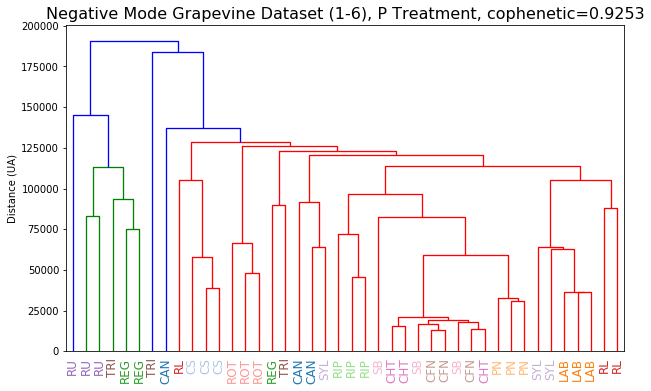

In [29]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_neg = treat_neg['P']
dist_P_neg = dist.pdist(P_neg.T, metric = 'euclidean')
Z_P_neg = hier.linkage(dist_P_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg, dist_P_neg)[0] 

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-6), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg, title)

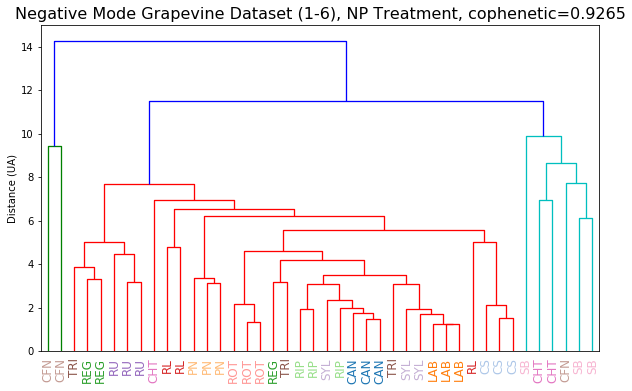

In [30]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_neg = treat_neg['NP']
dist_NP_neg = dist.pdist(NP_neg.T, metric = 'euclidean')
Z_NP_neg = hier.linkage(dist_NP_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg, dist_NP_neg)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-6), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg, title)

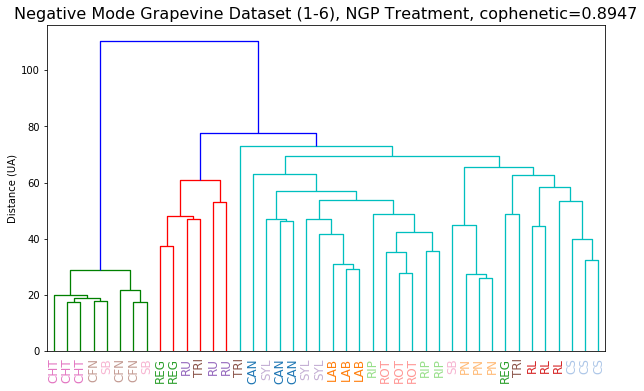

In [31]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_neg = treat_neg['NGP']
dist_NGP_neg = dist.pdist(NGP_neg.T, metric = 'euclidean')
Z_NGP_neg = hier.linkage(dist_NGP_neg, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg, dist_NGP_neg)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-6), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Negative GD)

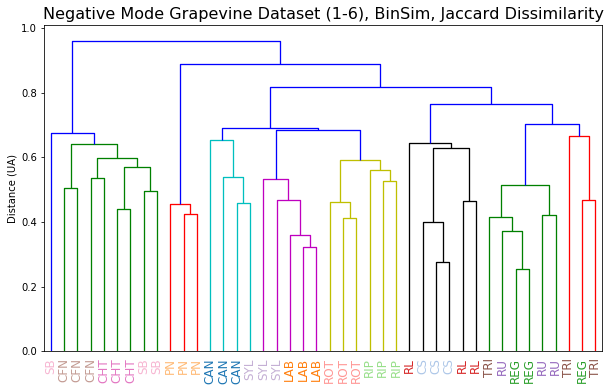

In [32]:
binary = treat_neg['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-6), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

## Positive Mode GD - 1-6 Alignment/Filtering - Dendrograms of each differently-treated PGD

In [33]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_pos = treat_pos['Ionly']
dist_Imp_pos = dist.pdist(Imp_pos.T, metric = 'euclidean')
Z_Imp_pos = hier.linkage(dist_Imp_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_pos, dist_Imp_pos)[0]

# Plot the dendrogram
#title = f'Positive Mode Grapevine Dataset (1-6), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_pos, title)

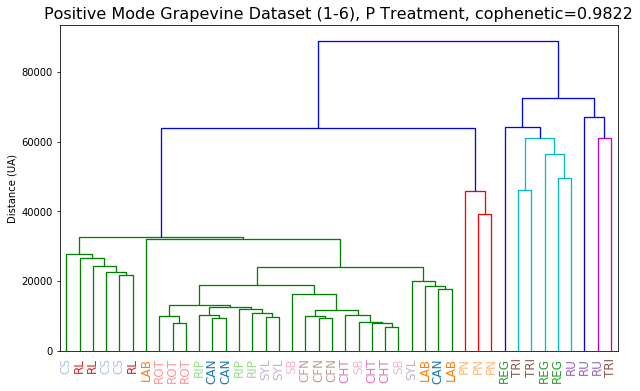

In [34]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_pos = treat_pos['P']
dist_P_pos = dist.pdist(P_pos.T, metric = 'euclidean')
Z_P_pos = hier.linkage(dist_P_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos, dist_P_pos)[0]

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-6), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos, title)

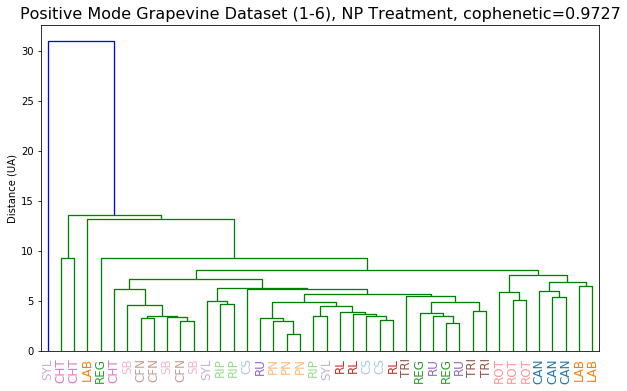

In [35]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_pos = treat_pos['NP']
dist_NP_pos = dist.pdist(NP_pos.T, metric = 'euclidean')
Z_NP_pos = hier.linkage(dist_NP_pos, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos, dist_NP_pos)[0] 

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-6), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos, title)

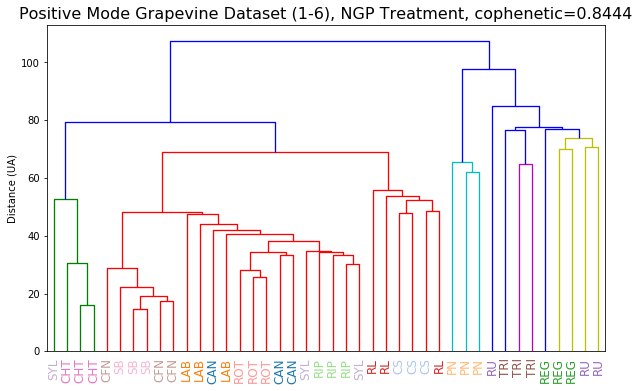

In [36]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_pos = treat_pos['NGP']
dist_NGP_pos = dist.pdist(NGP_pos.T, metric = 'euclidean')
Z_NGP_pos = hier.linkage(dist_NGP_pos, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos, dist_NGP_pos)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-6), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Positive GD)

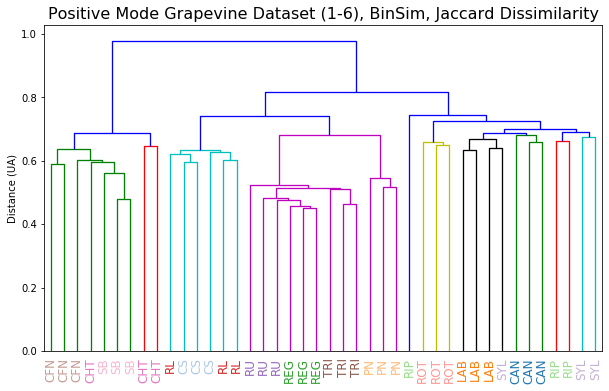

In [37]:
binary = treat_pos['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-6), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

## 2nd Peak Alignment - Negative Mode GD - 1-13 Alignment/Filtering - Dendrograms of each differently-treated NGD

Each feature appears in at least 13 of the 39 samples. Appears as 1_13 in figures (may appear as 1_2).

Presented with 2 following the names. Example: treat_neg2.

Same types of processing as before.

In [38]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_neg2 = treat_neg2['Ionly']
dist_Imp_neg2 = dist.pdist(Imp_neg2.T, metric = 'euclidean')
Z_Imp_neg2 = hier.linkage(dist_Imp_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_neg2, dist_Imp_neg2)[0]

# Plot the dendrogram
#title = f'Negative Mode Grapevine Dataset (1-13), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_neg2, title)

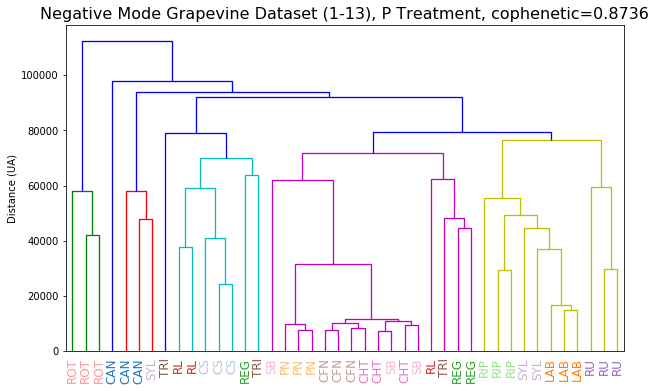

In [39]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_neg2 = treat_neg2['P']
dist_P_neg2 = dist.pdist(P_neg2.T, metric = 'euclidean')
Z_P_neg2 = hier.linkage(dist_P_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_neg2, dist_P_neg2)[0] 

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-13), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_neg2, title)

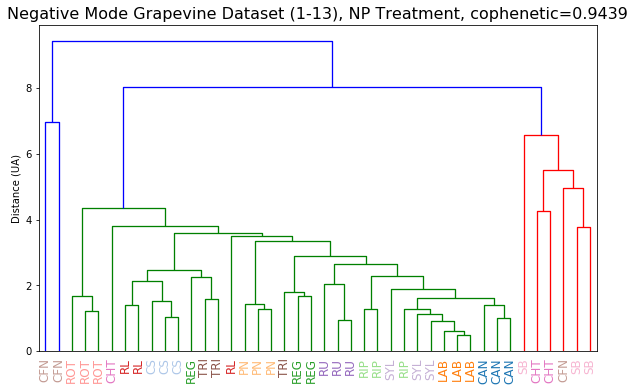

In [40]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_neg2 = treat_neg2['NP']
dist_NP_neg2 = dist.pdist(NP_neg2.T, metric = 'euclidean')
Z_NP_neg2 = hier.linkage(dist_NP_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_neg2, dist_NP_neg2)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-13), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_neg2, title)

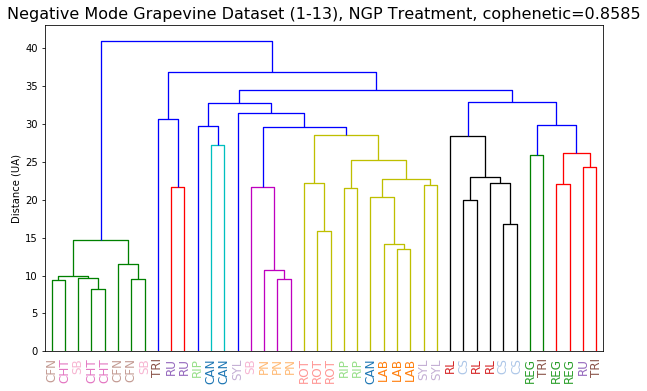

In [41]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_neg2 = treat_neg2['NGP']
dist_NGP_neg2 = dist.pdist(NGP_neg2.T, metric = 'euclidean')
Z_NGP_neg2 = hier.linkage(dist_NGP_neg2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_neg2, dist_NGP_neg2)[0]

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-13), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_neg2, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Negative GD)

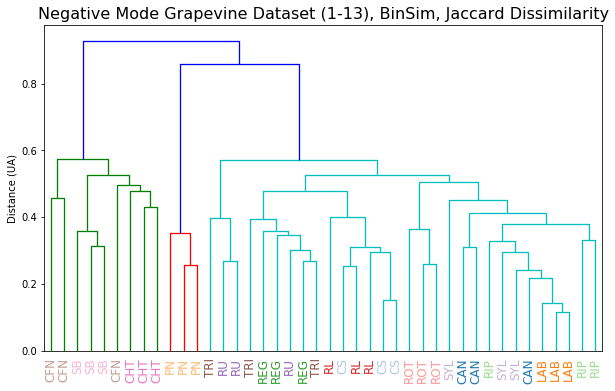

In [42]:
binary = treat_neg2['binary']

# Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Negative Mode Grapevine Dataset (1-13), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

## Positive Mode GD - 1-13 Alignment/Filtering - Dendrograms of each differently-treated PGD

In [43]:
# Missing Value Imputation only
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Imp_pos2 = treat_pos2['Ionly']
dist_Imp_pos2 = dist.pdist(Imp_pos2.T, metric = 'euclidean')
Z_Imp_pos2 = hier.linkage(dist_Imp_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
#coph = hier.cophenet(Z_Imp_pos2, dist_Imp_pos2)[0]

# Plot the dendrogram
#title = f'Positive Mode Grapevine Dataset (1-13), Euclidean, NaN Imputation, cophenetic={coph:.4f}'
#plot_dendogram(Z_Imp_pos2, title)

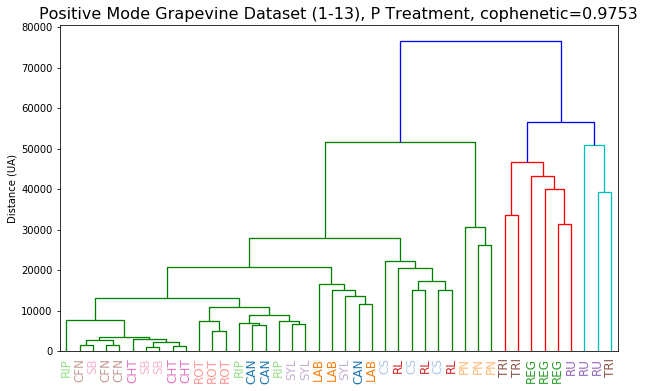

In [44]:
# Imputed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
P_pos2 = treat_pos2['P']
dist_P_pos2 = dist.pdist(P_pos2.T, metric = 'euclidean')
Z_P_pos2 = hier.linkage(dist_P_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_P_pos2, dist_P_pos2)[0]

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-13), P Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_P_pos2, title)

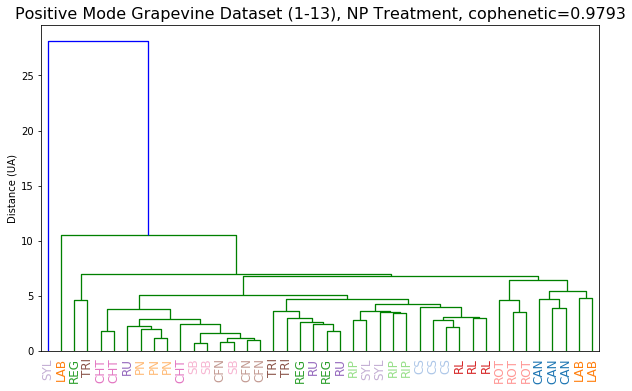

In [45]:
# Imputed, Normalized (reference feature) and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NP_pos2 = treat_pos2['NP']
dist_NP_pos2 = dist.pdist(NP_pos2.T, metric = 'euclidean')
Z_NP_pos2 = hier.linkage(dist_NP_pos2, method = 'average') # ward, average, centroid, single, complete, weighted, median

# Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NP_pos2, dist_NP_pos2)[0] 

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-13), NP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NP_pos2, title)

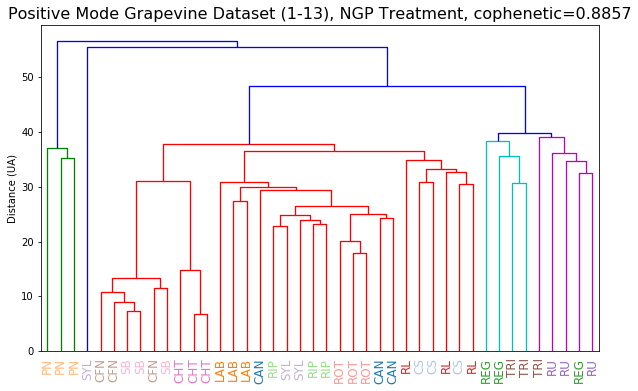

In [46]:
# Imputed, Normalized (reference feature), glog transformed and Pareto scaled
# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
NGP_pos2 = treat_pos2['NGP']
dist_NGP_pos2 = dist.pdist(NGP_pos2.T, metric = 'euclidean')
Z_NGP_pos2 = hier.linkage(dist_NGP_pos2, method = 'average') #ward, average, centroid, single, complete, weighted, median

#Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
coph = hier.cophenet(Z_NGP_pos2, dist_NGP_pos2)[0] #method average seems to lead to higher coefficients

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-13), NGP Treatment, cophenetic={coph:.4f}'
plot_dendogram(Z_NGP_pos2, title)

### Binary Similarity (BinSim) Pre-Treatment - Example Dendogram with Jaccard Dissimilarity (Positive GD)

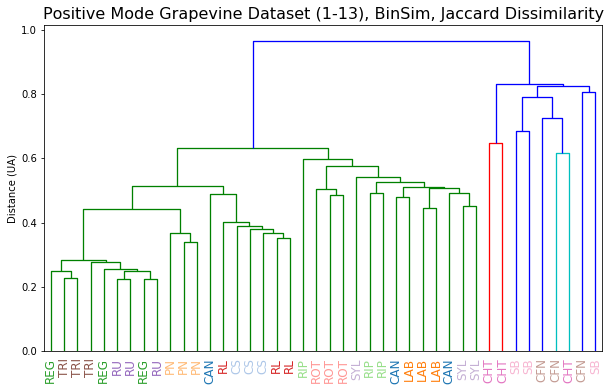

In [47]:
binary = treat_pos2['binary']

#Apply one of the following: dice, hamming, jaccard, rogerstanimoto, sokalmichener, sokalsneath, yule, kulsinski, rusellrao.

# Calculating the distance matrix (between the samples) of the treated dataset and build the linkage matrix of the HCA
Z_bin = hier.linkage(binary.T, metric='jaccard', method='average')

# Plot the dendrogram
title = f'Positive Mode Grapevine Dataset (1-13), BinSim, Jaccard Dissimilarity'
plot_dendogram(Z_bin, title)

## Similarity Comparison of the dendrograms made with all binary metrics and euclidean distances from the differently-treated datasets - Not organized

#### Two methods: Cophenetic Correlation Coefficient and Baker's Gamma Correlation Coefficient

Baker's Gamma Correlation: Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper (Spearman Correlation according to R package 'dendextend').

Correlation Cophenetic Correlation: Pearson Correlation of the matrix of cophenetic distances of two different dendrograms.

### Traditionally-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

In [48]:
euclidean = (Z_P_neg, Z_NP_neg, Z_NGP_neg, Z_P_pos, Z_NP_pos, Z_NGP_pos,
            Z_P_neg2, Z_NP_neg2, Z_NGP_neg2, Z_P_pos2, Z_NP_pos2, Z_NGP_pos2)
dist_euclidean = (dist_P_neg, dist_NP_neg, dist_NGP_neg, dist_P_pos, dist_NP_pos, dist_NGP_pos,
                 dist_P_neg2, dist_NP_neg2, dist_NGP_neg2, dist_P_pos2, dist_NP_pos2, dist_NGP_pos2)

K_BG = []
S_BG = []
Coph_C = []

for i, (eu, d) in enumerate(zip(euclidean, dist_euclidean)):
    K_BG.append(ma.mergerank(eu)) # Mergerank
    S_BG.append(K_BG[i][K_BG[i]!=0]) # Both reshape to a 1D array (needed for spearman correlation) and take out 0's 
    Coph_C.append(hier.cophenet(eu, d)) # Matrix of Cophenetic distances

#### Examples of procedure with these methods with the Negative Grapevine Dataset (Alignment 1-6)

#### Cophenetic Correlation Coefficient

In [49]:
# Apply np.corrcoef since cophenet function returns elements in the same order
print('Pair of samples      \tPearson Correlation \tp-value')
print('P Treat-NP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[1][1])[1])
print('P Treat-NGP Treat\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[0], '\t', stats.pearsonr(Coph_C[0][1],Coph_C[2][1])[1])

Pair of samples      	Pearson Correlation 	p-value
P Treat-NP Treat	 -0.03623409499286148 	 0.2882293268106453
P Treat-NGP Treat	 0.27113330952984427 	 5.661500424116939e-16


#### Baker's Gamma Correlation Coefficient

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

In [50]:
print('Pair of samples      \tKendall Correlation \tp-value')
print('P Treat-NP Treat\t', stats.kendalltau(S_BG[0],S_BG[1])[0], '\t', stats.kendalltau(S_BG[0],S_BG[1])[1])
print('P Treat-NGP Treat\t', stats.kendalltau(S_BG[0],S_BG[2])[0], '\t', stats.kendalltau(S_BG[0],S_BG[2])[1])

Pair of samples      	Kendall Correlation 	p-value
P Treat-NP Treat	 0.04735795737820598 	 0.008285138863551514
P Treat-NGP Treat	 0.22581972859351218 	 9.044016894209275e-35


According to the explanation given in the R package dendextend

In [51]:
print('Pair of samples      \tSpearman Correlation \tp-value')
print('P Treat-NP Treat\t', stats.spearmanr(S_BG[0],S_BG[1])[0], '\t', stats.spearmanr(S_BG[0],S_BG[1])[1])
print('P Treat-NGP Treat\t', stats.spearmanr(S_BG[0],S_BG[2])[0], '\t', stats.spearmanr(S_BG[0],S_BG[2])[1])

Pair of samples      	Spearman Correlation 	p-value
P Treat-NP Treat	 0.03142488967099091 	 0.1924337177261225
P Treat-NGP Treat	 0.2437063674519074 	 1.0579837705629392e-24


### BinSim-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

Also building linkage matrices (HCA) using all different binary distance metrics.

Change between number of binary metrics to use.

In [52]:
# 9 binary methods accepted in pdist (scipy.spatial.distances.pdist)
binary = ('dice', 'hamming', 'jaccard', 'rogerstanimoto', 'sokalmichener', 'sokalsneath', 'yule', 'kulsinski', 'russellrao')
# 3 methods that will be used as representative of the others (others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [53]:
bin_neg = treat_neg['binary']
bin_pos = treat_pos['binary']
bin_neg2 = treat_neg2['binary']
bin_pos2 = treat_pos2['binary']

In [54]:
# Application of all "single" steps needed presented in the examples above with every distance metric.
# Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(bin_neg.T, metric = binary[i], method='average')) # Z
    K_neg.append(ma.mergerank(Z_neg[i])) # Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) # Eliminating 0s
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(bin_neg.T, metric = binary[i]))) # Cophenetic

In [55]:
# Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(bin_pos.T, metric = binary[i], method='average')) # Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0s
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(bin_pos.T, metric = binary[i]))) # Cophenetic

### Calculating the correlation between the dendrograms - Last step, calculate each pairwise correlation

Choose what set of linkage matrices (one for each differently-treated dataset) to consider when calculating similarity between them.

In [56]:
# Creation of a list with all the "rank" values (in order) for the different metrics: 
# Negative Traditional, Positive Traditional, Negative BinSims, Positive BinSims
S = S_BG + S_neg + S_pos

# Creation of a list with all the returns from the function cophenetic for the different metrics: 
# Negative Traditional, Positive Traditional, Negative BinSims, Positive BinSims
Coph = Coph_C + Coph_neg + Coph_pos

Creation of all dataframes needed to store all correlation coeficients and respective p-values for all three methods

In [57]:
# Column names and row names for the dataframes
#3 binary metrics
#colnames = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
#            'P_neg1_13', 'NP_neg1_13', 'NGP_neg1_13', 'P_pos1_13', 'NP_pos1_13', 'NGP_pos1_13', 
#            'hamming_neg1_6', 'jaccard_neg1_6', 'yule_neg1_6',  'hamming_pos1_6', 'jaccard_pos1_6', 'yule_pos1_6']

# 9 binary metrics
colnames = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
            'P_neg1_13', 'NP_neg1_13', 'NGP_neg1_13', 'P_pos1_13', 'NP_pos1_13', 'NGP_pos1_13',
            'dice_neg1_6', 'hamming_neg1_6', 'jaccard_neg1_6', 'rogerstanimoto_neg1_6', 'sokalmichener_neg1_6', 
            'sokalsneath_neg1_6','yule_neg1_6', 'kulsinski_neg1_6', 'russellrao_neg1_6','dice_pos1_6', 'hamming_pos1_6', 
            'jaccard_pos1_6', 'rogerstanimoto_pos1_6', 'sokalmichener_pos1_6', 'sokalsneath_pos1_6', 'yule_pos1_6', 
            'kulsinski_pos1_6', 'russellrao_pos1_6']

In [58]:
nS = len(S)
correlations = {key: np.zeros((nS,nS)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

for i in range(nS):
    for j in range(nS):
        Si, Sj = S[i],S[j]
        # K - Kendall (Baker)
        ktau = stats.kendalltau(Si,Sj)
        correlations['K'][i,j], correlations['K_p'][i,j] = ktau
        # S - Spearman (Baker)
        spearmanr = stats.stats.spearmanr(Si,Sj)
        correlations['S'][i,j], correlations['S_p'][i,j] = spearmanr
        # C - Cophenetic Correlation
        coph = stats.pearsonr(Coph[i][1],Coph[j][1])
        correlations['C'][i,j], correlations['C_p'][i,j] = coph

for k in correlations:
    correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)

In [59]:
# Calculation of correlation coefficient for each method

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,nS))* np.nan, columns=colnames, index=[''])
lineV = pd.concat([line.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, columns =[''], index = ['']), line.iloc[:,12:]], axis = 1)

def prepare_corr_df(df):
    prep = pd.concat([df.iloc[:12], line, df.iloc[12:]])
    prep = pd.concat([prep.iloc[:,:12], lineV.T, prep.iloc[:,12:]], axis = 1)
    return prep

df_KI = prepare_corr_df(correlations['K'])
df_SI = prepare_corr_df(correlations['S'])
df_CI = prepare_corr_df(correlations['C'])

### Heatmaps of the correlation coeficients for the 3 methods

Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


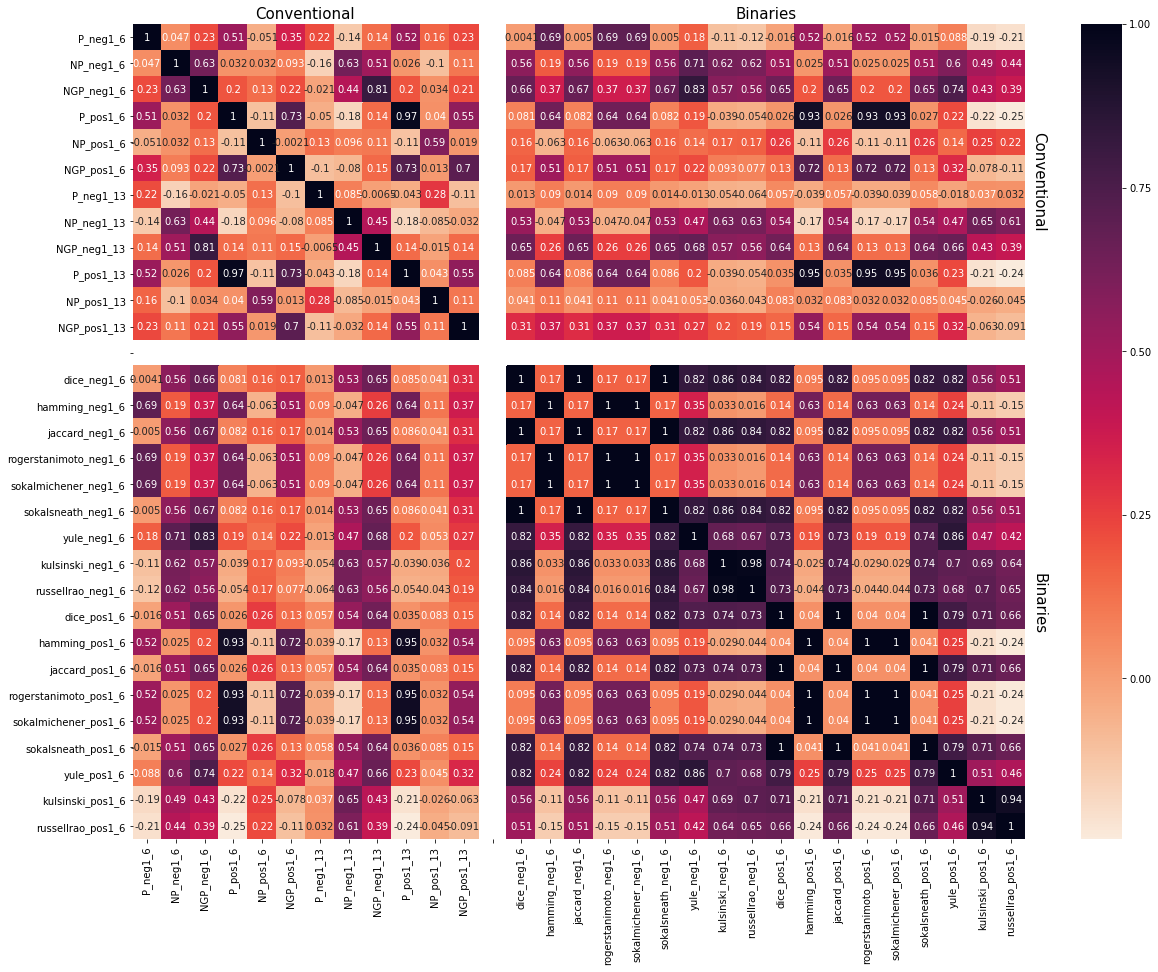

In [60]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Kendall) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
hm = sns.heatmap(df_KI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


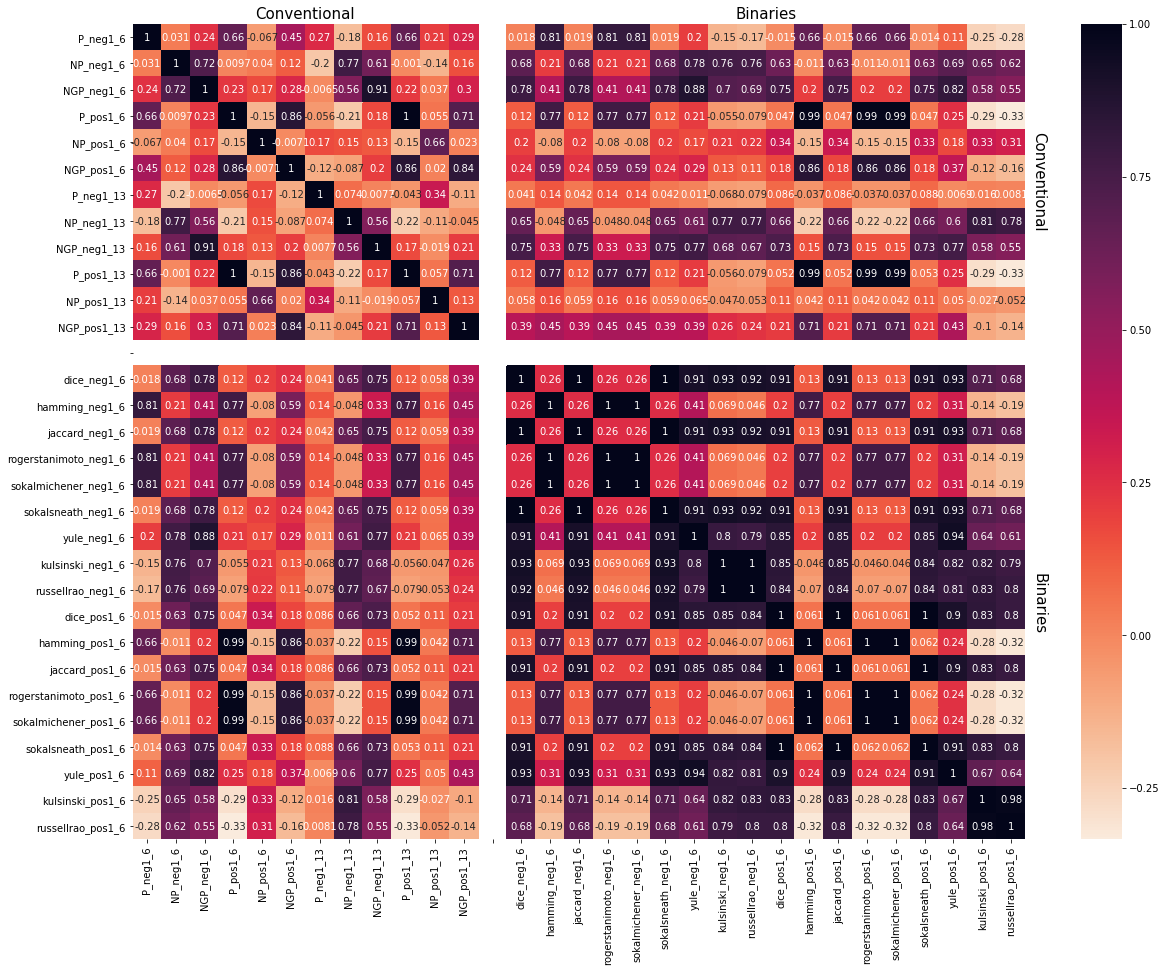

In [61]:
f, ax = plt.subplots(figsize=(20, 15))

print('Baker (Spearman) Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
hm = sns.heatmap(df_SI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


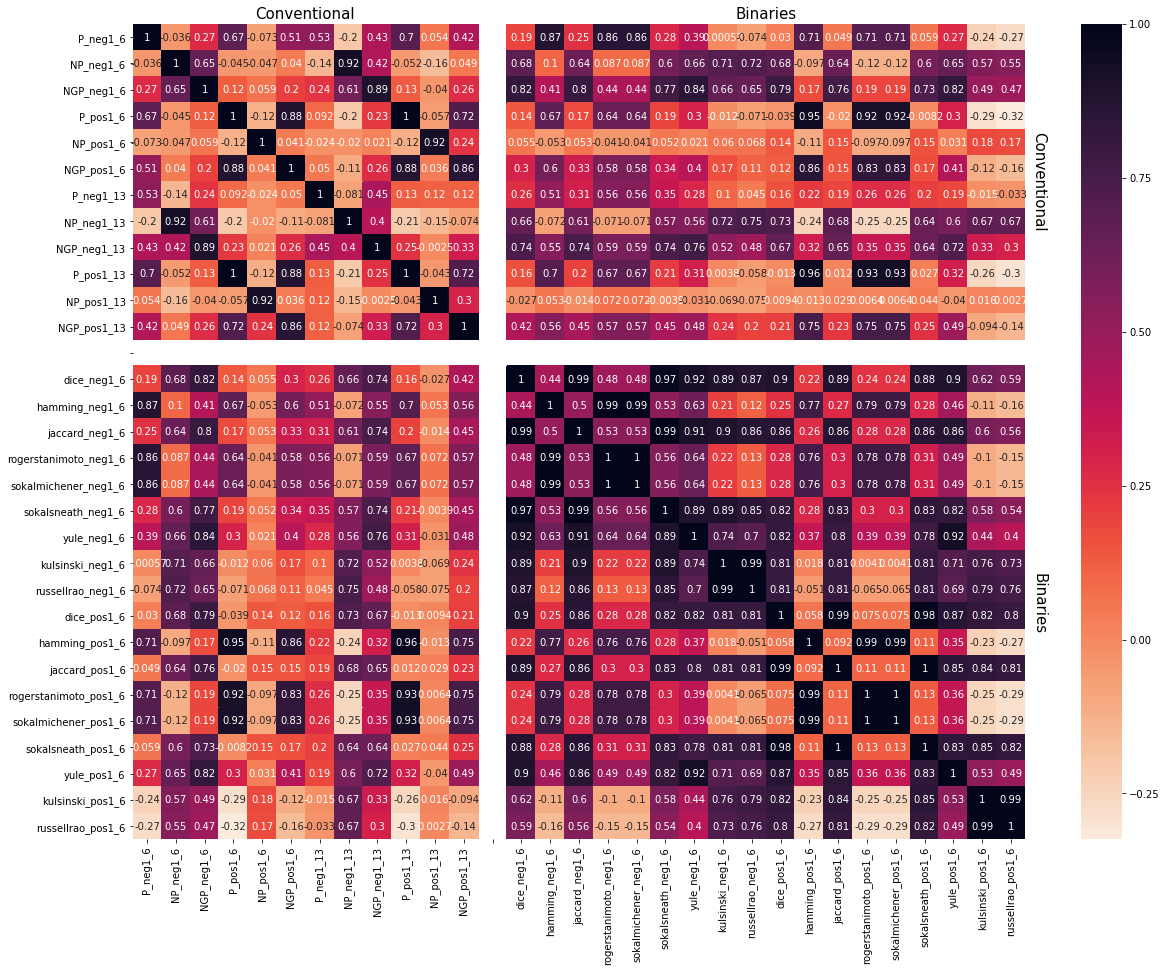

In [62]:
f, ax = plt.subplots(figsize=(20, 15))

print('Cophenetic Correlation Coefficient Heatmap (between dendrograms made with different distance metrics)')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
hm = sns.heatmap(df_CI, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(6,-0.2,'Conventional', fontsize  = 15, horizontalalignment='center')
plt.text(31.2,6,'Conventional', fontsize  = 15, rotation = 270, verticalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 15, horizontalalignment='center') #16
plt.text(31.2,22,'Binaries', fontsize  = 15, rotation = 270, verticalalignment='center') #16
plt.show()

### Hierarchical clustering of the correlation coeficients of dendrograms made with different distance metrics with each other

Different colours for the Negative GD treated traditionally, Positive GD treated traditionally, Negative GD treated with BinSim (different binary distance metrics) and Positive GD treated with BinSim (different binary distance metrics) from the first alignment and from the second alignment.

In [63]:
label_colors2 = {}
colours2 = cm.get_cmap('nipy_spectral', 6)
col_lbl2 = colours2(range(6))
for i in range(4):
    label_colors2[colnames[3*i]] = col_lbl2[i]
    label_colors2[colnames[3*i+1]] = col_lbl2[i]
    label_colors2[colnames[3*i+2]] = col_lbl2[i]
for i in range(9):
    label_colors2[colnames[12+i]] = col_lbl2[4]
    label_colors2[colnames[21+i]] = col_lbl2[5]

Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


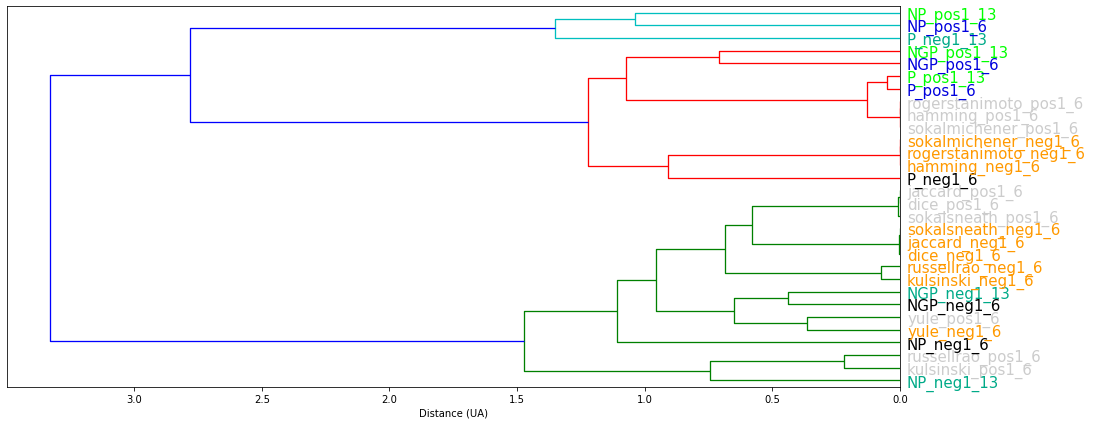

In [64]:
print('Hierarchical clustering of the Baker (Kendall) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
Z_K = hier.linkage(correlations['K'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_K, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


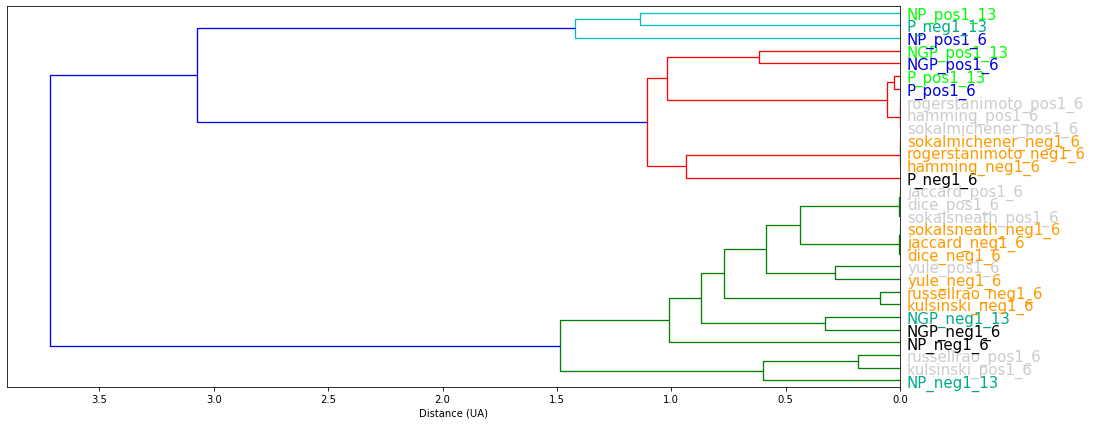

In [65]:
print('Hierarchical clustering of the Baker (Spearman) Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
Z_S = hier.linkage(correlations['S'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_S, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics
Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode
1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.
1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.


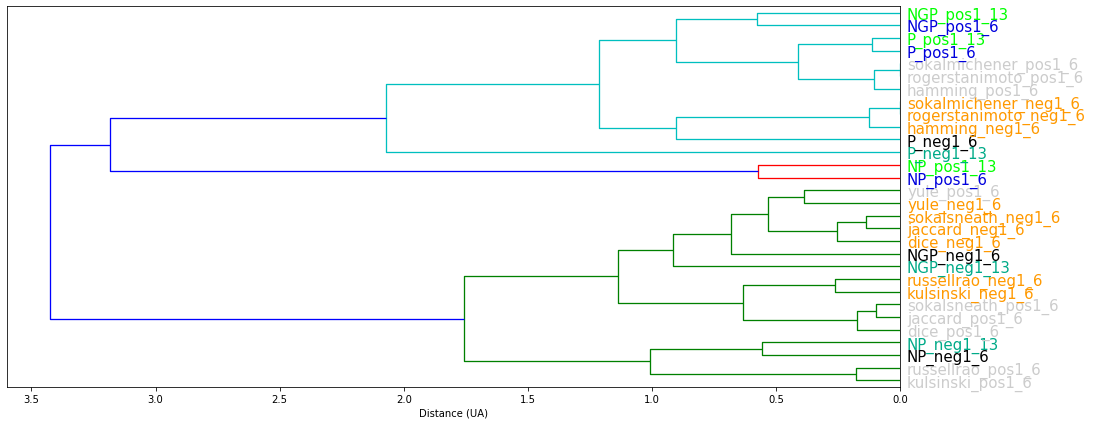

In [66]:
print('Hierarchical clustering of the Cophenetic Correlation Coefficients of the dendrograms made with different distance metrics')
print('Name Convention: First 12: Euclidean_DataProcessing_Mode; Last 18: DistanceMetric_Mode')
print('1_6 - Peak alignment requiring that a feature appears in at least 6 samples of all samples.')
print('1_13 - Peak alignment requiring that a feature appears at least in 13 samples of all samples.')
Z_C = hier.linkage(correlations['C'], metric = 'euclidean', method = 'average')
fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_C, labels=colnames,
                     leaf_font_size=15,
                     above_threshold_color='b',
                     orientation = 'left')
#Coloring labels
ax = plt.gca()
ax.set_xlabel('Distance (UA)')
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors2[lbl.get_text()])

### Comparing HCAs (Dendrograms) Discrimination

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [67]:
# Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [68]:
disc_average = np.zeros((1,30)) # Discrimination Distance
#disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30)) # Correct Clustering Percentage
disc_1stclust = np.zeros((1,30)) # Correct First Cluster Percentage Storing

for i in range(len(Z)):
    data = aligned_all_neg
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 14, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames) # Transforming into %s

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,12:]], axis = 1)
#disc_median = pd.concat([disc_median.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
#                                                columns = ['distances median']).T, disc_median.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
disc_1stclust = pd.concat([disc_1stclust.iloc[:,:12], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct 1st cluster']).T, disc_1stclust.iloc[:,12:]], axis = 1)

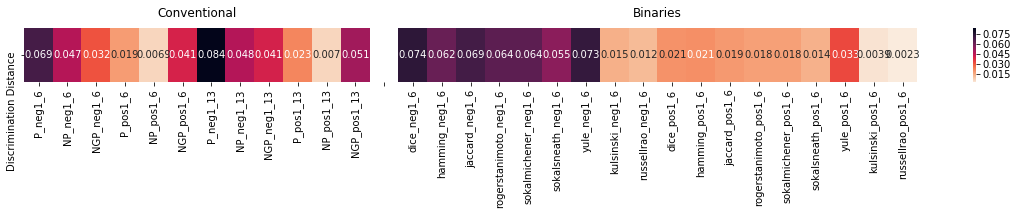

In [69]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(6,-0.2,'Conventional', fontsize  = 12, horizontalalignment='center')
plt.text(22,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

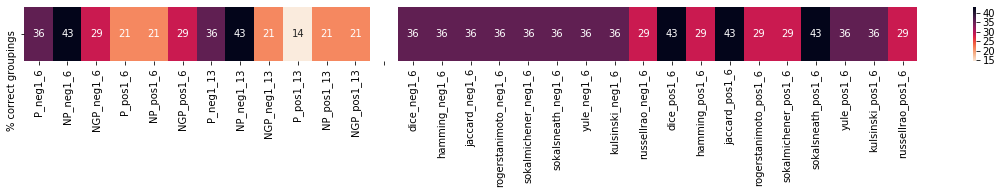

In [70]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

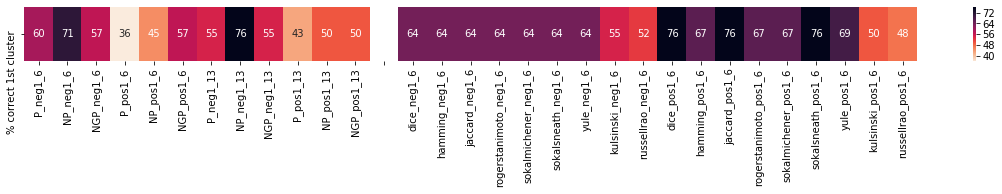

In [71]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust, annot=True, ax=ax, cmap = sns.cm.rocket_r)

### 1-13 Dendrograms with Binary distance metrics - Discrimination Measures

In [72]:
# Negative mode
Z_neg = []
K_neg = []
S_neg = []
Coph_neg = []

for i in range(len(binary)):
    Z_neg.append(hier.linkage(bin_neg2.T, metric = binary[i], method='average')) #Z
    K_neg.append(ma.mergerank(Z_neg[i])) #Mergerank
    S_neg.append(K_neg[i][K_neg[i]!=0]) #Eliminating 0's
    Coph_neg.append(hier.cophenet(Z_neg[i], dist.pdist(bin_neg2.T, metric = binary[i]))) #Cophenetic

# Positive Mode
Z_pos = []
K_pos = []
S_pos = []
Coph_pos = []

for i in range(len(binary)):
    Z_pos.append(hier.linkage(bin_pos2.T, metric = binary[i], method='average')) #Z
    K_pos.append(ma.mergerank(Z_pos[i])) #Mergerank
    S_pos.append(K_pos[i][K_pos[i]!=0]) #Eliminating 0's
    Coph_pos.append(hier.cophenet(Z_pos[i], dist.pdist(bin_pos2.T, metric = binary[i]))) #Cophenetic

In [73]:
# Preparing Z linkage matrices
Z = []
Z.extend(euclidean)
Z.extend(Z_neg)
Z.extend(Z_pos)

In [74]:
colnames_ex = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
            'P_neg1_13', 'NP_neg1_13', 'NGP_neg1_13', 'P_pos1_13', 'NP_pos1_13', 'NGP_pos1_13',
            'dice_neg1_13', 'hamming_neg1_13', 'jaccard_neg1_13', 'rogerstanimoto_neg1_13', 'sokalmichener_neg1_13', 
            'sokalsneath_neg1_13','yule_neg1_13', 'kulsinski_neg1_13', 'russellrao_neg1_13', 'dice_pos1_13', 'hamming_pos1_13', 
            'jaccard_pos1_13', 'rogerstanimoto_pos1_13', 'sokalmichener_pos1_13', 'sokalsneath_pos1_13', 'yule_pos1_13', 
            'kulsinski_pos1_13', 'russellrao_pos1_13']

In [75]:
disc_average = np.zeros((1,30))
#disc_median = np.zeros((1,30))
disc_correct = np.zeros((1,30))
disc_1stclust = np.zeros((1,30))

for i in range(len(Z)):
    data = aligned_all_neg
    
    # Discrimination Distance and Correct Clustering Percentage
    discrim = ma.dist_discrim(data, Z[i], method = 'average')  # all samples have the same order
    disc_average[0,i] = discrim[0]
    #disc_median[0,i] = ma.dist_discrim(data, Z[i], 'median')[0] # all samples have the same order
    correct = np.array(list(discrim[1].values()))
    disc_correct[0,i] = len(correct[correct>0])
    
    # Correct First Cluster Percentage
    disc_1stclust[0,i] = ma.correct_1stcluster_fraction(data, Z[i]) # all samples have the same order
    
# Transforming results into DataFrames    
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames_ex)
disc_correct = pd.DataFrame(disc_correct * 100 / 14, index = ['% correct groupings'], columns = colnames_ex) 
disc_1stclust = pd.DataFrame(disc_1stclust * 100, index = ['% correct 1st cluster'], columns = colnames_ex)

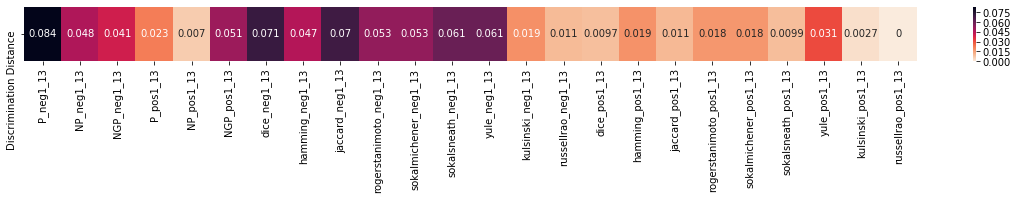

In [76]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

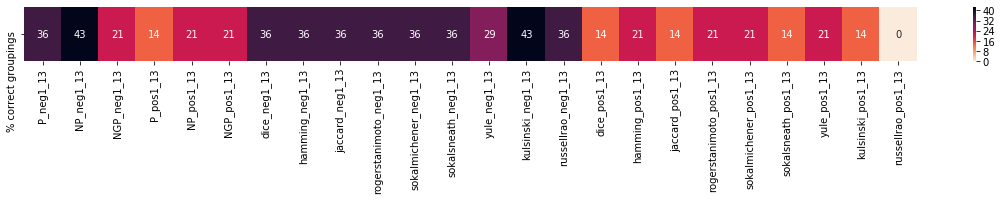

In [77]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

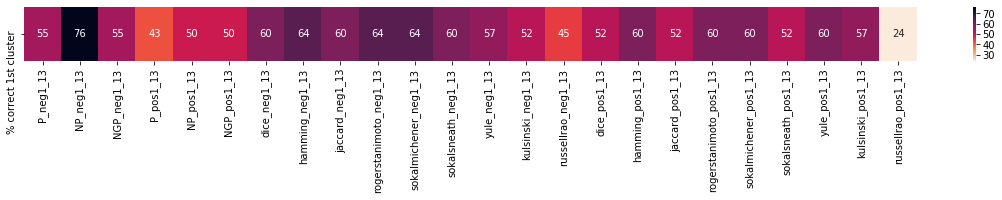

In [78]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_1stclust.iloc[:,6:], annot=True, ax=ax, cmap = sns.cm.rocket_r)

### Extra binary similarity measures of peak alignment 2: 1-13

In [79]:
sim_pos2 = mz_similarity(aligned_all_pos2, has_labels = True)
sim_neg2 = mz_similarity(aligned_all_neg2, has_labels = True)

Sample HC, NEGATIVE mode, Peak Alignment: 1-13


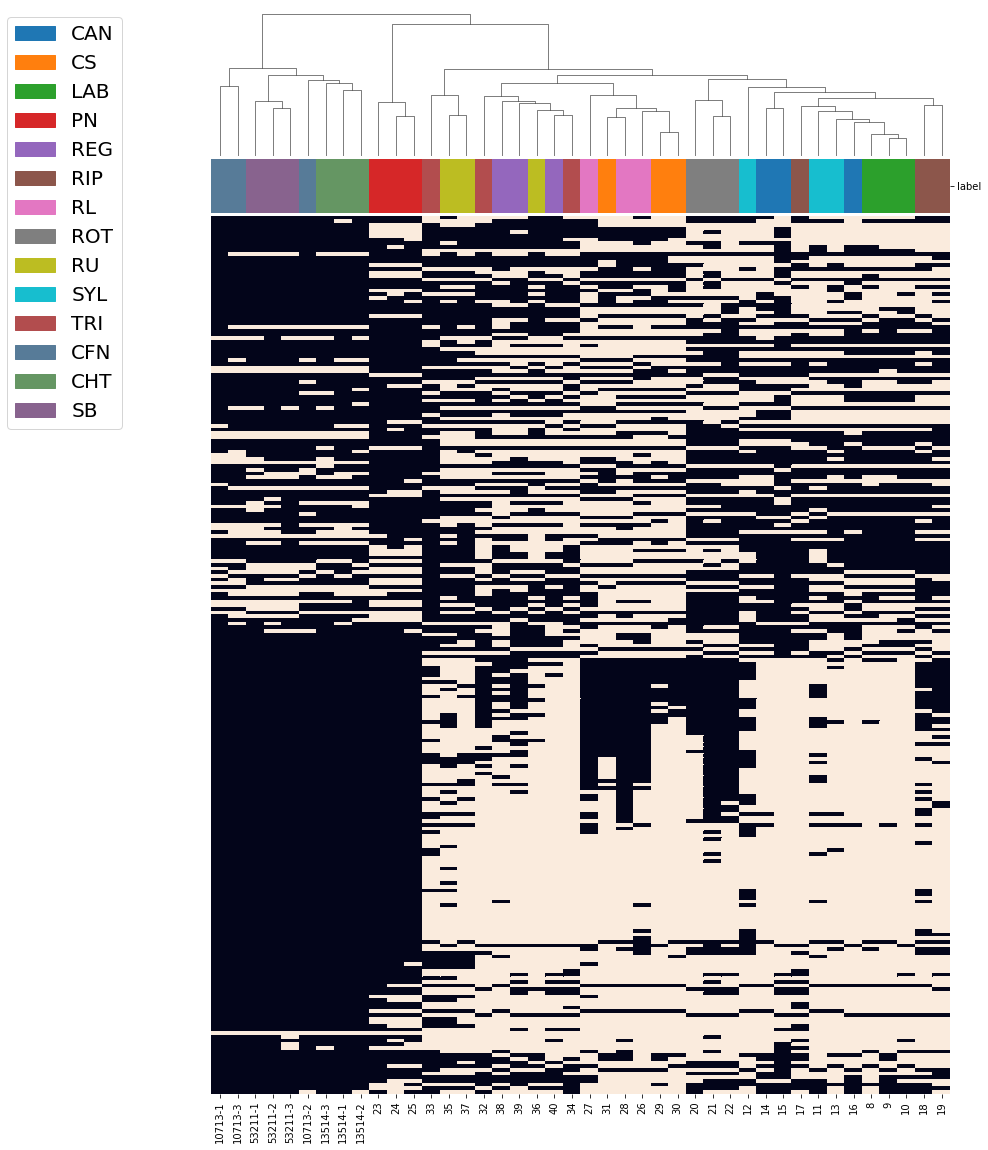

In [80]:
print('Sample HC, NEGATIVE mode, Peak Alignment: 1-13')
g = clustermap_peak_list(aligned_all_neg2)

Sample HC, POSITIVE mode, Peak Alignment: 1-13


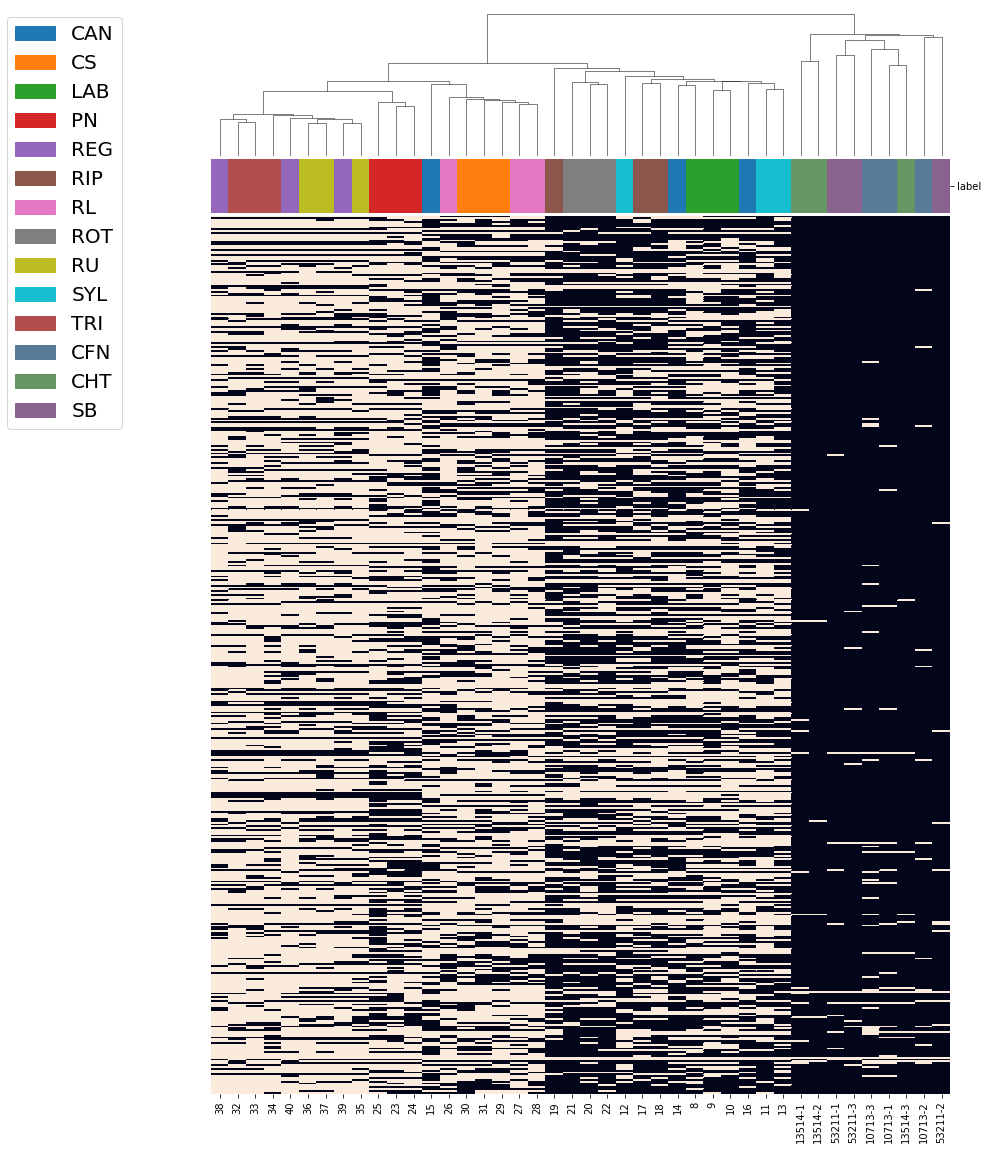

In [81]:
print('Sample HC, POSITIVE mode, Peak Alignment: 1-13')
g = clustermap_peak_list(aligned_all_pos2)

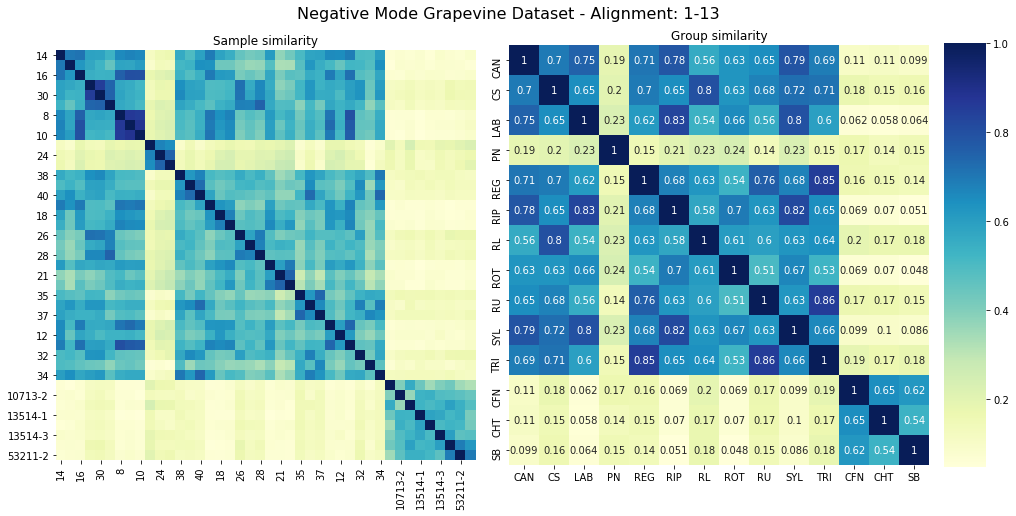

In [82]:
plot_jaccard_sims(aligned_all_neg2, 'Negative Mode Grapevine Dataset - Alignment: 1-13')

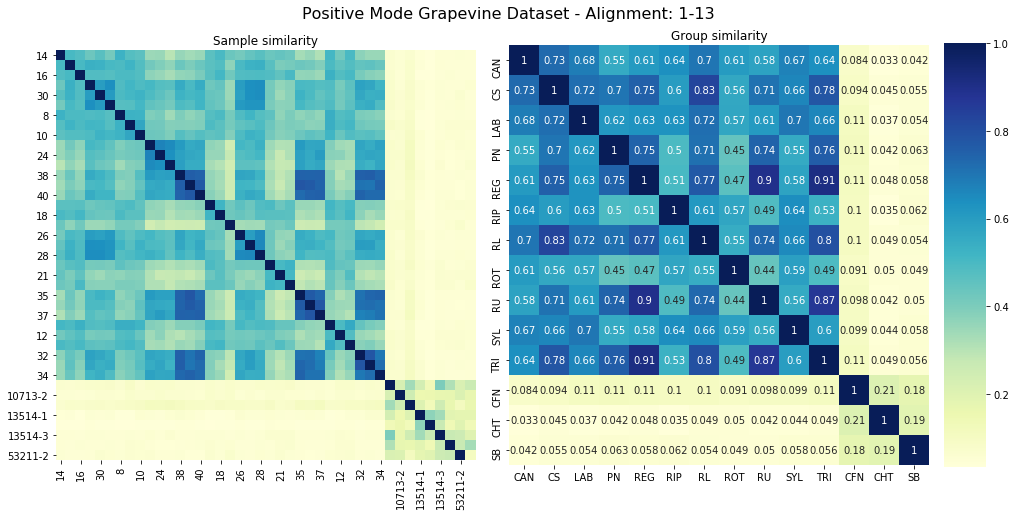

In [83]:
plot_jaccard_sims(aligned_all_pos2, 'Positive Mode Grapevine Dataset - Alignment: 1-13')

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [84]:
import sklearn.cluster as skclust

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

In [85]:
Kmean = skclust.KMeans(n_clusters=13)

In [86]:
a = Kmean.fit(NGP_neg.T)

In [87]:
dicto = {}

for i, lbl in enumerate(a.labels_):
    dicto.setdefault(lbl, []).append(all_labels[i])
dicto

{5: ['CAN', 'CAN', 'SYL'],
 7: ['CAN', 'RIP'],
 6: ['CS', 'CS', 'CS'],
 3: ['LAB', 'LAB', 'LAB', 'SYL', 'SYL'],
 0: ['PN', 'PN', 'PN', 'SB'],
 11: ['REG', 'TRI'],
 9: ['REG', 'REG', 'RU', 'TRI'],
 1: ['RIP', 'RIP', 'ROT', 'ROT', 'ROT'],
 8: ['RL', 'RL'],
 12: ['RL'],
 4: ['RU', 'RU'],
 10: ['TRI'],
 2: ['CFN', 'CFN', 'CFN', 'CHT', 'CHT', 'CHT', 'SB', 'SB']}

Adjusted Rand Index

In [88]:
from sklearn.metrics import adjusted_rand_score
a.labels_
NGP_neg.cdl.labels
adjusted_rand_score(NGP_neg.cdl.labels,a.labels_)

0.4104823747680891

### K-means clustering applied to all euclidean methods and the binary matrixes built

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [89]:
colnames2 = ['P_neg1_6', 'NP_neg1_6', 'NGP_neg1_6', 'P_pos1_6', 'NP_pos1_6', 'NGP_pos1_6',
             'P_neg1_13', 'NP_neg1_13', 'NGP_neg1_13', 'P_pos1_13', 'NP_pos1_13', 'NGP_pos1_13',
             'binary_neg1_6', 'binary_pos1_6','binary_neg1_13', 'binary_pos1_13']

In [90]:
Data = (P_neg, NP_neg, NGP_neg, P_pos, NP_pos, NGP_pos,
        P_neg2, NP_neg2, NGP_neg2, P_pos2, NP_pos2, NGP_pos2, 
        bin_neg, bin_pos, bin_neg2, bin_pos2)

In [91]:
disc_average = np.zeros((1,16)) # Discrimination Distance
disc_correct = np.zeros((1,16)) # Correct Clustering Percentage
disc_rand = np.zeros((1,16)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames2)
disc_correct = pd.DataFrame(disc_correct * 100 /14, index = ['% correct groupings'], columns = colnames2) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames2)

#Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame(np.empty((1,1))* np.nan, index = [''])
disc_average = pd.concat([disc_average.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Discrimination Distance']).T, disc_average.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['Discrimination Distance']).T, disc_average.iloc[:,12:]], axis = 1)
disc_correct = pd.concat([disc_correct.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['% correct groupings']).T, disc_correct.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['% correct groupings']).T, disc_correct.iloc[:,12:]], axis = 1)
disc_rand = pd.concat([disc_rand.iloc[:,:6], pd.DataFrame(np.empty((1,1))* np.nan, index = [''],
                                                columns = ['Rand Index']).T, disc_rand.iloc[:,6:12], 
                                                pd.DataFrame(np.empty((1,1))* np.nan, index = [''], columns = 
                                                ['Rand Index']).T, disc_rand.iloc[:,12:]], axis = 1)

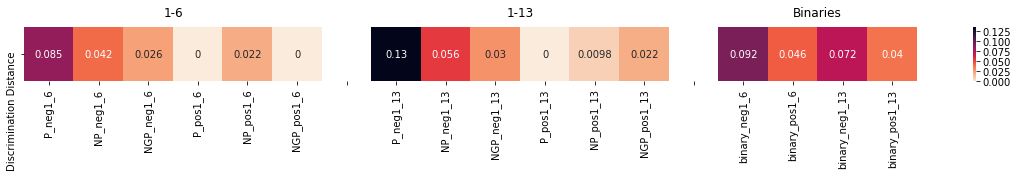

In [92]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.text(3,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(10,-0.2,'1-13', fontsize  = 12, horizontalalignment='center')
plt.text(16,-0.2,'Binaries', fontsize = 12, horizontalalignment='center')
plt.show()

In [93]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(disc_median, annot=True, ax=ax, cmap = sns.cm.rocket_r)

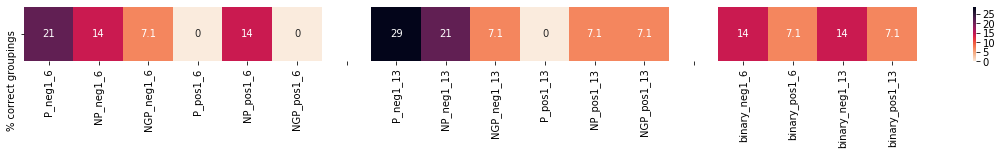

In [94]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

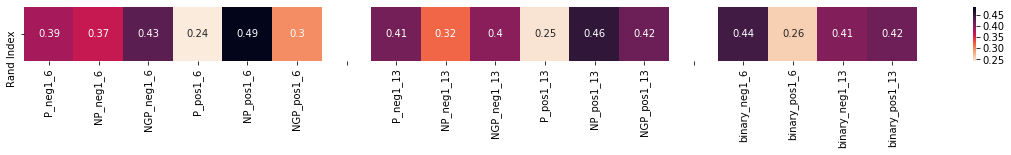

In [95]:
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA. The performance of the models/classifiers built will be evaluated by their predictive accuracy (which will always be estimated by internal stratified 3-fold cross-validation).

Internal stratified 3-fold cross-validation was used to estimate the model's performance since that is maximum number possible since every group of samples only has 3 replicates in the dataset.

In [96]:
# Centralize data information in a dictionary
datasets = {}

#datasets['I_neg'] = treat_neg['Ionly']
datasets['P_neg'] = treat_neg['P']
datasets['NP_neg'] = treat_neg['NP']
datasets['NGP_neg'] = treat_neg['NGP']
datasets['BinSim_neg'] = treat_neg['binary']

#datasets['I_pos'] = treat_pos['Ionly']
datasets['P_pos'] = treat_pos['P']
datasets['NP_pos'] = treat_pos['NP']
datasets['NGP_pos'] = treat_pos['NGP']
datasets['BinSim_pos'] = treat_pos['binary']

#datasets['I_neg2'] = treat_neg2['Ionly']
datasets['P_neg2'] = treat_neg2['P']
datasets['NP_neg2'] = treat_neg2['NP']
datasets['NGP_neg2'] = treat_neg2['NGP']
datasets['BinSim_neg2'] = treat_neg2['binary']

#datasets['I_pos2'] = treat_pos2['Ionly']
datasets['P_pos2'] = treat_pos2['P']
datasets['NP_pos2'] = treat_pos2['NP']
datasets['NGP_pos2'] = treat_pos2['NGP']
datasets['BinSim_pos2'] = treat_pos2['binary']

## Random Forests

### Test number of trees needed for predictive accuracy convergence for N, NP, NGP and BinSim treated data

Random Forest models with different number of trees will be built to assess when the predictive accuracy of the different models stops increasing with higher number of trees.

Grid search of number of trees from 10 to 400 for the random forests. See where the cross-validation estimated predictive accuracy stops improving for each one.

#### Takes  some time

In [97]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
#Vector with values for the parameter n_estimators
values = {'n_estimators': range(10,400,10)}

rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [98]:
param = []
test_score = []
for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, all_labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting P_neg ... Done!
Fitting NP_neg ... Done!
Fitting NGP_neg ... Done!
Fitting BinSim_neg ... Done!
Fitting P_pos ... Done!
Fitting NP_pos ... Done!
Fitting NGP_pos ... Done!
Fitting BinSim_pos ... Done!
Fitting P_neg2 ... Done!
Fitting NP_neg2 ... Done!
Fitting NGP_neg2 ... Done!
Fitting BinSim_neg2 ... Done!
Fitting P_pos2 ... Done!
Fitting NP_pos2 ... Done!
Fitting NGP_pos2 ... Done!
Fitting BinSim_pos2 ... Done!


Performance based on number of trees - Alignment: 1-6, Negative Mode


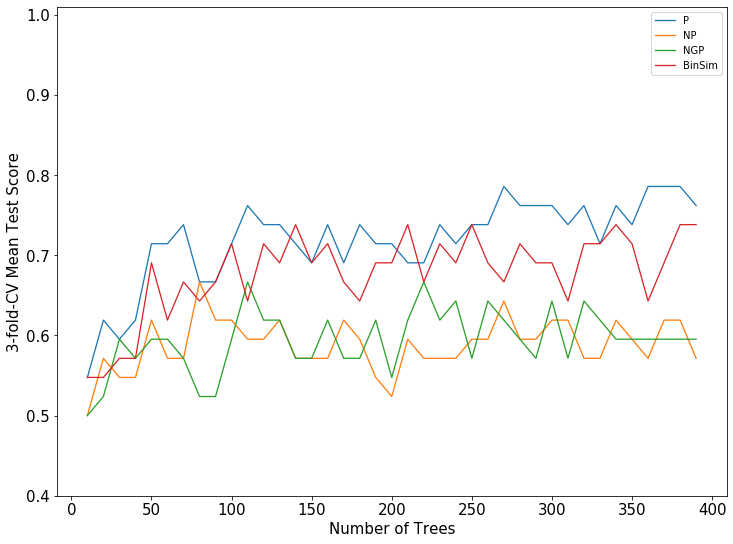

In [99]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(4):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Negative Mode')

Performance based on number of trees - Alignment: 1-6, Positive Mode


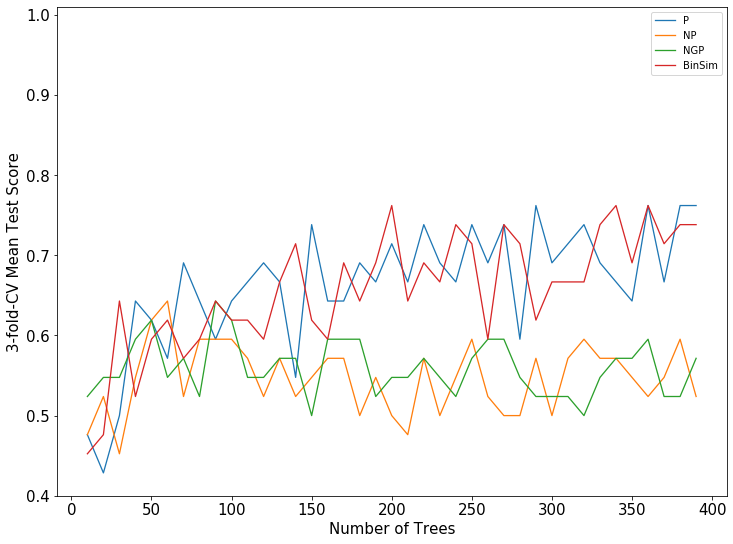

In [100]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(4,8):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-6, Positive Mode')

Performance based on number of trees - Alignment: 1-13, Negative Mode


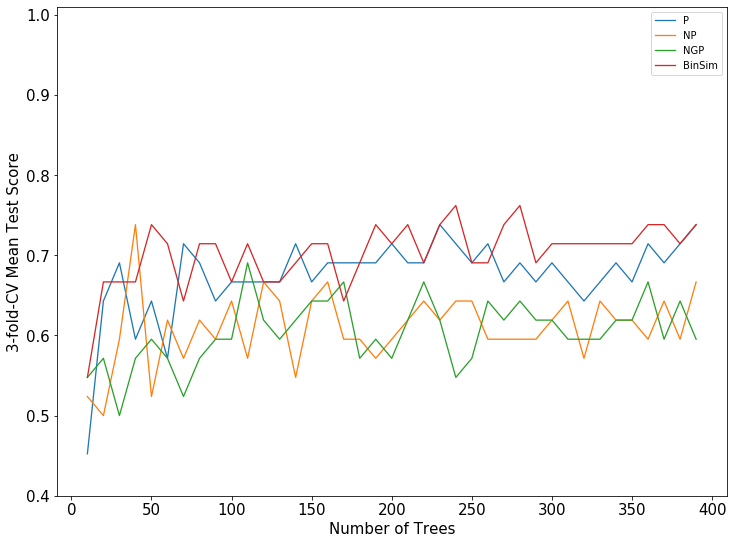

In [101]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(8,12):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-13, Negative Mode')

Performance based on number of trees - Alignment: 1-13, Positive Mode


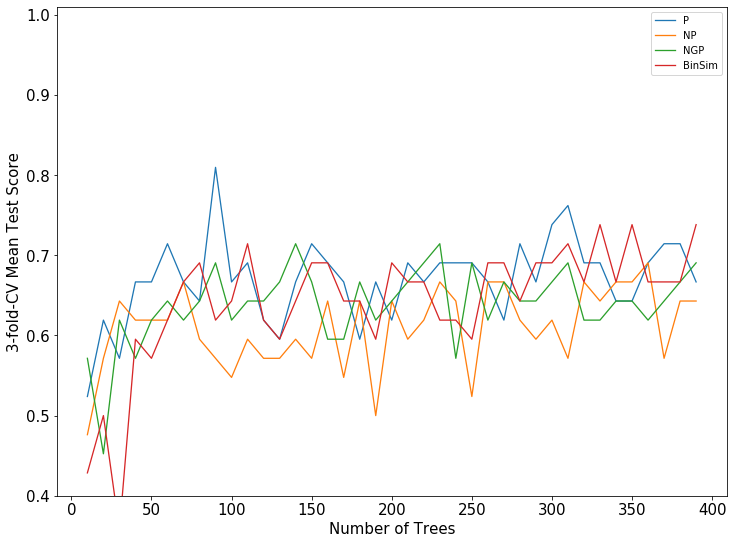

In [102]:
f, ax = plt.subplots(figsize=(12,9))
for i in range(12,16):
    plt.plot(param[i], test_score[i])
plt.ylabel('3-fold-CV Mean Test Score', fontsize = 15)
plt.xlabel('Number of Trees', fontsize = 15)
ax.legend(('P', 'NP', 'NGP', 'BinSim'))
plt.ylim(0.4,1.01)
ax.tick_params(axis='both', which='major', labelsize=15)
print('Performance based on number of trees - Alignment: 1-13, Positive Mode')

### Random Forest Application

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 3-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset.

Use of the `simple_RF` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [103]:
Teste = {}
Teste_std = {}
Teste_feat = {}

In [104]:
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Teste[name] = rf
    Teste_std[name] = np.std(rf)
    Teste_feat[name] = imp_features
    print(f'done')    

Fitting random forest for P_neg ...done
Fitting random forest for NP_neg ...done
Fitting random forest for NGP_neg ...done
Fitting random forest for BinSim_neg ...done
Fitting random forest for P_pos ...done
Fitting random forest for NP_pos ...done
Fitting random forest for NGP_pos ...done
Fitting random forest for BinSim_pos ...done
Fitting random forest for P_neg2 ...done
Fitting random forest for NP_neg2 ...done
Fitting random forest for NGP_neg2 ...done
Fitting random forest for BinSim_neg2 ...done
Fitting random forest for P_pos2 ...done
Fitting random forest for NP_pos2 ...done
Fitting random forest for NGP_pos2 ...done
Fitting random forest for BinSim_pos2 ...done


Accuracy based on the dataset


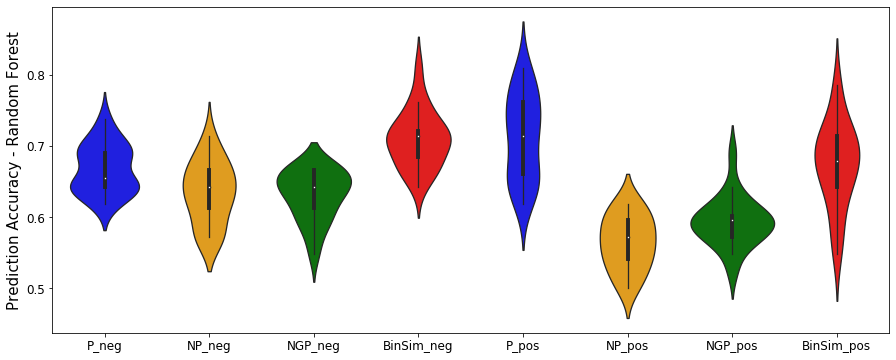

In [105]:
f, ax = plt.subplots(figsize=(15,6))
data = pd.DataFrame.from_dict(Teste)
colors = ['blue','orange','green','red']
sns.violinplot( data = data.iloc[:,:8], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

Accuracy based on the dataset


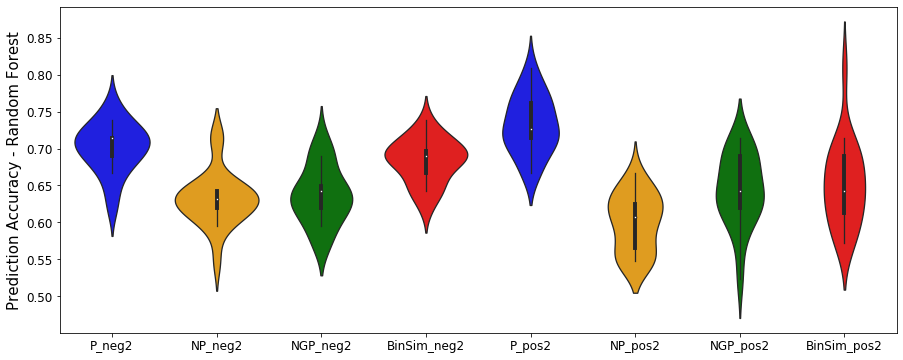

In [106]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
sns.violinplot( data = data.iloc[:,8:], palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - Random Forest', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize = 12)
print('Accuracy based on the dataset')

In [107]:
Teste_A = {}
for i in Teste:
    Teste_A[i] = np.mean(Teste[i])

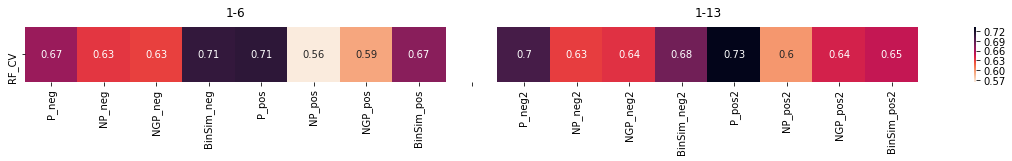

In [108]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys()).T
# Inserting blank lines in the DataFrame for better presentation and separation
Teste_H = pd.concat([Teste_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_H.iloc[:,8:]], axis = 1)
f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Teste_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV'])
plt.text(4,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'1-13', fontsize  = 12, horizontalalignment='center')
plt.show()

In [109]:
#Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
#Teste_std_H = pd.concat([Teste_std_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Teste_std_H.iloc[:,8:]], 
#                        axis = 1)
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(Teste_std_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_CV_std'])

In [110]:
Teste_H = pd.DataFrame(list(Teste_A.values()), index = Teste_A.keys(), columns = ['Accuracy']).T
Teste_std_H = pd.DataFrame(list(Teste_std.values()), index = Teste.keys()).T
#Teste_ic = Teste_std_H / (100**0.5)*1.96

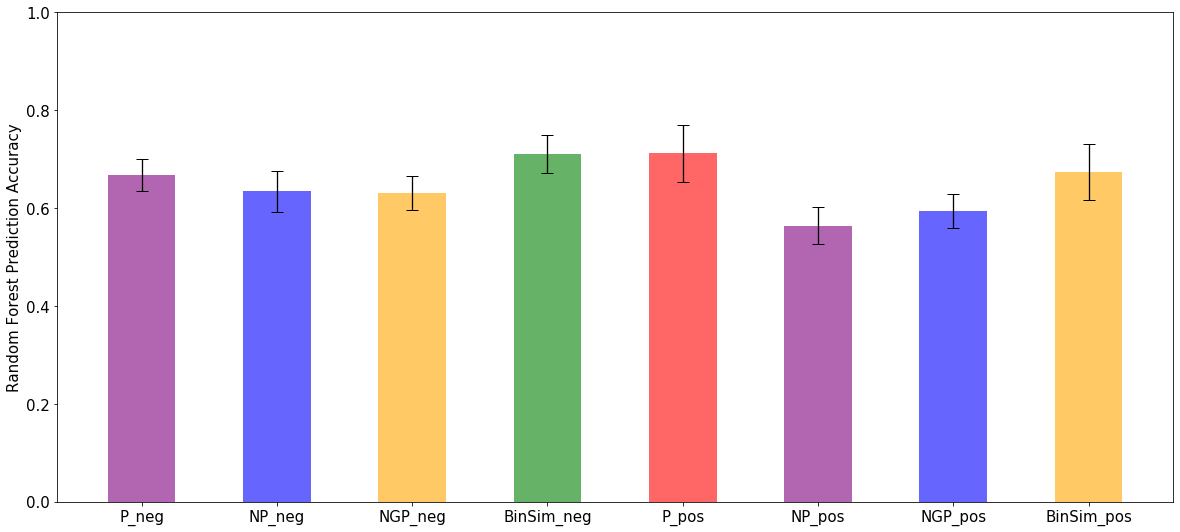

In [111]:
#sns.set_context('notebook')
f, ax = plt.subplots(figsize=(20, 9))

color = ['purple','blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][0:8], x = Teste_H.columns[0:8], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[0:8], y = Teste_H.T['Accuracy'][0:8], yerr = Teste_std_H.iloc[0,:8], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

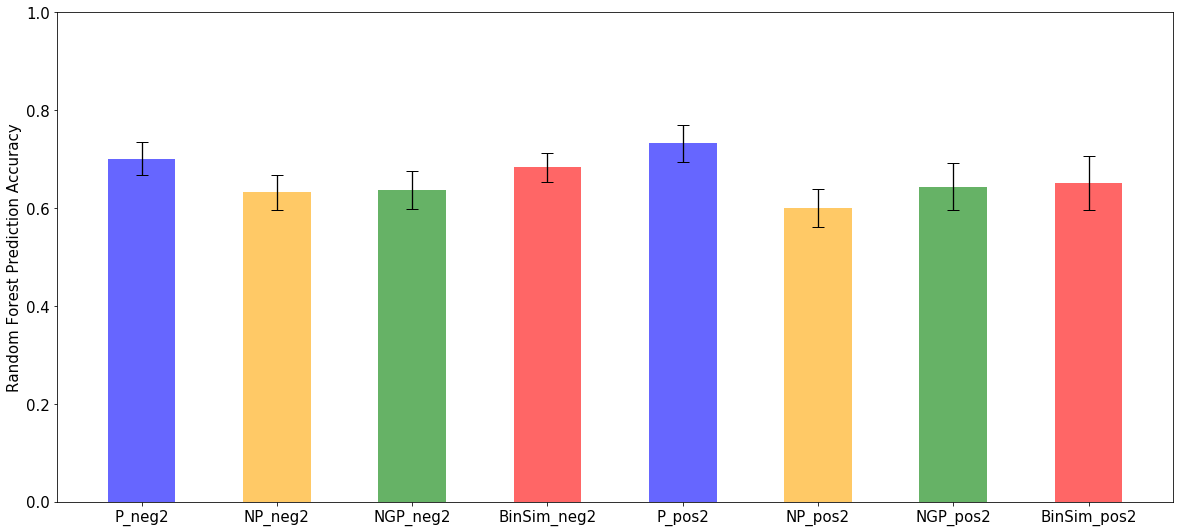

In [112]:
f, ax = plt.subplots(figsize=(20, 9))

color = ['blue','orange','green','red']
plt.bar(height = Teste_H.T['Accuracy'][8:], x = Teste_H.columns[8:], width = 0.5, color = color, alpha = 0.6)
ax.errorbar(x = Teste_H.columns[8:], y = Teste_H.T['Accuracy'][8:], yerr = Teste_std_H.iloc[0,8:], 
            ls = 'none', ecolor = 'black', capsize = 6)
plt.ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Random Forest Prediction Accuracy', fontsize = 15)
plt.show()

### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

We take the 2% most important features in each case and calculate the median number of samples those features appear (samples_m), the median number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). 

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('explained').

### Alignments 1-6 and 1-13

In [113]:
# Getting the number of samples, groups, ratios for each important feature, 
# magnitude for most important feature and calculating % explained by these features (explained)
ev = []
magni = []
explained = []
for name in Teste_feat:
    if name.endswith('neg'):
        #continue
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        #continue
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        #continue
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        #continue
        Spectra = aligned_all_pos2
        
    imp_features = Teste_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    # Top 2%
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra)))
    
    a = 0
    for i in range(number): 
        a = a + imp_features[i][1]*100 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    explained.append(a)
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)
#print(ev[4])

In [114]:
# Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = [i  for i in Teste_feat]) #if '2-1' in i])
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)

# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:]])

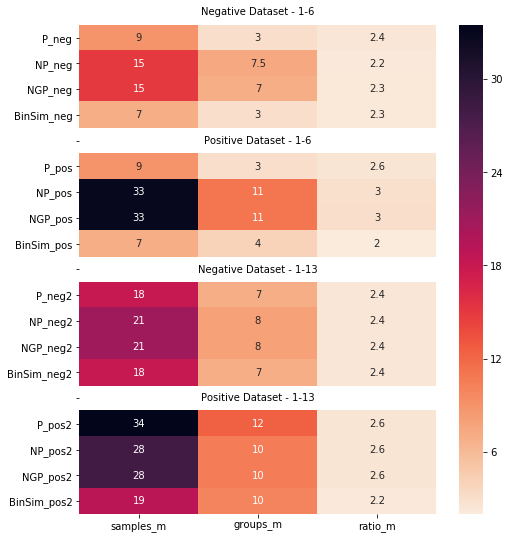

In [115]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.text(1.5,-0.5,'Negative Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 1-13',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 1-13',horizontalalignment='center', verticalalignment='center')
plt.show()

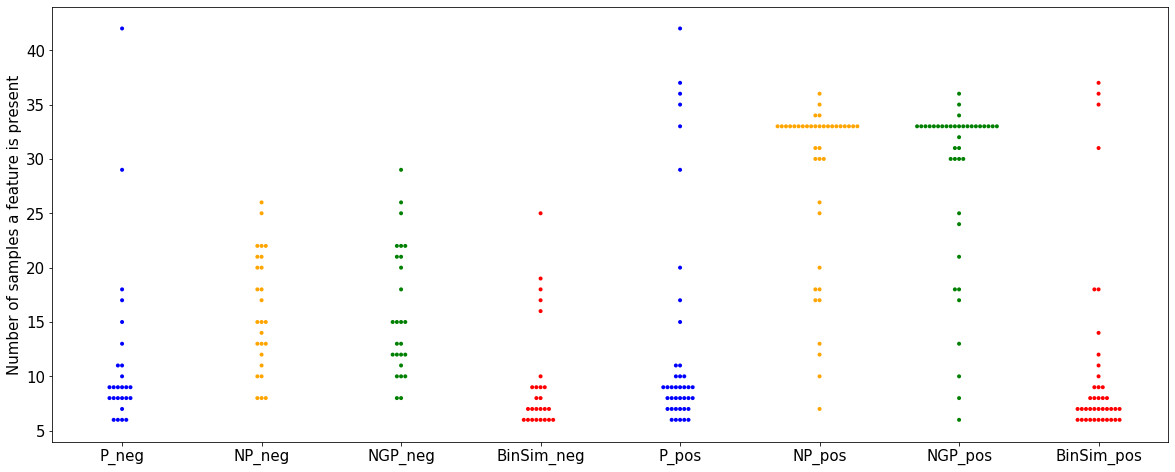

In [116]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][:8])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

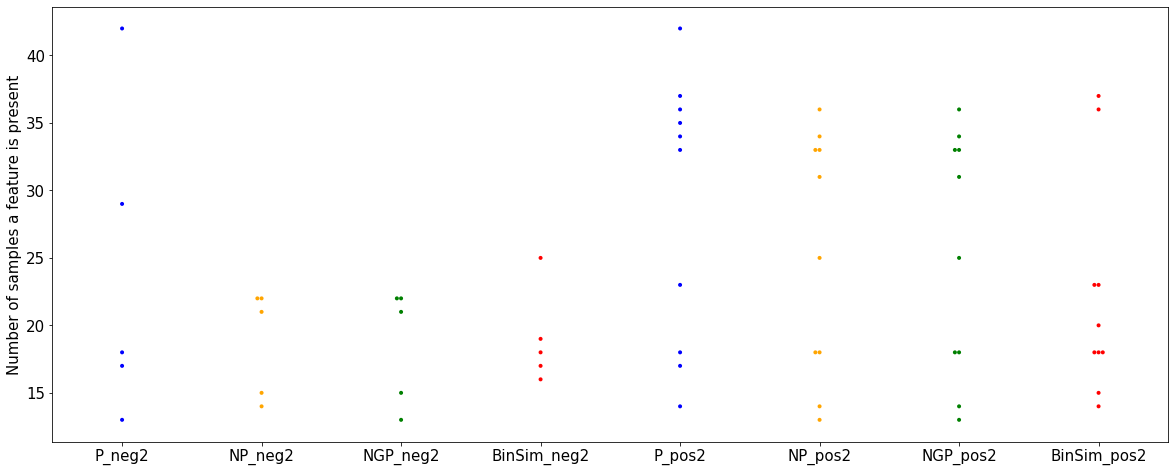

In [117]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#print(data)
#sns.violinplot(data=data)
sns.swarmplot(data=data[8:], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(Teste_feat.keys())[i][0:13] for i in range(len(Teste_feat.keys()))][8:])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [118]:
print('Magnitude of most important feature:', )
for i in range(16):
    print(list(Teste_feat.keys())[i], '  \t', magni[i])
    
print('\n')
print('% of model explained by the 2% most important features')
for i in range(16):
    print(list(Teste_feat.keys())[i], '  \t', explained[i])

Magnitude of most important feature:
P_neg   	 5.411678457736499
NP_neg   	 3.4210254156302606
NGP_neg   	 3.45644511092081
BinSim_neg   	 3.581480680912031
P_pos   	 7.872491396245926
NP_pos   	 3.8017801364144175
NGP_pos   	 3.9026728806163087
BinSim_pos   	 6.124220884327221
P_neg2   	 3.1093223332361553
NP_neg2   	 1.9124462144095615
NGP_neg2   	 1.9717712406598167
BinSim_neg2   	 2.7282775044126035
P_pos2   	 6.361912115541528
NP_pos2   	 2.408745120296124
NGP_pos2   	 2.3833477017721836
BinSim_pos2   	 3.290077805509967


% of model explained by the 2% most important features
P_neg   	 6.516822107989463
NP_neg   	 5.10371289860792
NGP_neg   	 5.248567111109876
BinSim_neg   	 5.306707843362341
P_pos   	 9.796352001747959
NP_pos   	 6.060199422918362
NGP_pos   	 6.147747982251984
BinSim_pos   	 7.218573309642518
P_neg2   	 5.344887122050334
NP_neg2   	 3.6186223901100307
NGP_neg2   	 3.6240437030183927
BinSim_neg2   	 5.388427387768328
P_pos2   	 8.338133046460358
NP_pos2   	 4.006

### See how overfit the random forests built are (only present in this notebook) - Nothing important

In [119]:
#Scores = {}
#for name, data in part.items():
#    print(f'Fitting random forest for {name} ...', end='')
#    rf, a, b, c = ma.overfit_RF(data)#, iter_num = 100)
#    Scores[name + '_overfit'] = np.mean(rf)
#    print(f'done') 

In [120]:
#Scores_H = pd.DataFrame(list(Scores.values()), index = Scores.keys()).T
#Scores_std_H = pd.DataFrame(list(Scores_std.values()), index = Scores_std.keys()).T

In [121]:
#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(Scores_H, annot=True, 
#                 ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['RF_Scores'])

## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

In [122]:
matrix = pd.get_dummies(all_labels)
matrix

CAN  CFN  CHT  CS  LAB  PN  REG  RIP  RL  ROT  RU  SB  SYL  TRI
0     1    0    0   0    0   0    0    0   0    0   0   0    0    0
1     1    0    0   0    0   0    0    0   0    0   0   0    0    0
2     1    0    0   0    0   0    0    0   0    0   0   0    0    0
3     0    0    0   1    0   0    0    0   0    0   0   0    0    0
4     0    0    0   1    0   0    0    0   0    0   0   0    0    0
5     0    0    0   1    0   0    0    0   0    0   0   0    0    0
6     0    0    0   0    1   0    0    0   0    0   0   0    0    0
7     0    0    0   0    1   0    0    0   0    0   0   0    0    0
8     0    0    0   0    1   0    0    0   0    0   0   0    0    0
9     0    0    0   0    0   1    0    0   0    0   0   0    0    0
10    0    0    0   0    0   1    0    0   0    0   0   0    0    0
11    0    0    0   0    0   1    0    0   0    0   0   0    0    0
12    0    0    0   0    0   0    1    0   0    0   0   0    0    0
13    0    0    0   0    0   0    1    0   0    0   0   0    0    0
14    0    0    0   0    0   0    1    0   0    0   0   0    0    0
15    0    0    0   0    0   0    0    1   0    0   0   0    0    0
16    0    0    0   0    0   0    0    1   0    0   0   0    0    0
17    0    0    0   0    0   0    0    1   0    0   0   0    0    0
18    0    0    0   0    0   0    0    0   1    0   0   0    0    0
19    0    0    0   0    0   0    0    0   1    0   0   0    0    0
20    0    0    0   0    0   0    0    0   1    0   0   0    0    0
21    0    0    0   0    0   0    0    0   0    1   0   0    0    0
22    0    0    0   0    0   0    0    0   0    1   0   0    0    0
23    0    0    0   0    0   0    0    0   0    1   0   0    0    0
24    0    0    0   0    0   0    0    0   0    0   1   0    0    0
25    0    0    0   0    0   0    0    0   0    0   1   0    0    0
26    0    0    0   0    0   0    0    0   0    0   1   0    0    0
27    0    0    0   0    0   0    0    0   0    0   0   0    1    0
28    0    0    0   0    0   0    0    0   0    0   0   0    1    0
29    0    0    0   0    0   0    0    0   0    0   0   0    1    0
30    0    0    0   0    0   0    0    0   0    0   0   0    0    1
31    0    0    0   0    0   0    0    0   0    0   0   0    0    1
32    0    0    0   0    0   0    0    0   0    0   0   0    0    1
33    0    1    0   0    0   0    0    0   0    0   0   0    0    0
34    0    1    0   0    0   0    0    0   0    0   0   0    0    0
35    0    1    0   0    0   0    0    0   0    0   0   0    0    0
36    0    0    1   0    0   0    0    0   0    0   0   0    0    0
37    0    0    1   0    0   0    0    0   0    0   0   0    0    0
38    0    0    1   0    0   0    0    0   0    0   0   0    0    0
39    0    0    0   0    0   0    0    0   0    0   0   1    0    0
40    0    0    0   0    0   0    0    0   0    0   0   1    0    0
41    0    0    0   0    0   0    0    0   0    0   0   1    0    0

### Optimization - Search for the best number of components to use - Alignment 1-6 and 1-13

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 3-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [123]:
# Store Results
PLS_optim = {}

In [124]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 50)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for P_neg ...done
Optimizing PLS-DA for NP_neg ...done
Optimizing PLS-DA for NGP_neg ...done
Optimizing PLS-DA for BinSim_neg ...done
Optimizing PLS-DA for P_pos ...done
Optimizing PLS-DA for NP_pos ...done
Optimizing PLS-DA for NGP_pos ...done
Optimizing PLS-DA for BinSim_pos ...done
Optimizing PLS-DA for P_neg2 ...done
Optimizing PLS-DA for NP_neg2 ...done
Optimizing PLS-DA for NGP_neg2 ...done
Optimizing PLS-DA for BinSim_neg2 ...done
Optimizing PLS-DA for P_pos2 ...done
Optimizing PLS-DA for NP_pos2 ...done
Optimizing PLS-DA for NGP_pos2 ...done
Optimizing PLS-DA for BinSim_pos2 ...done


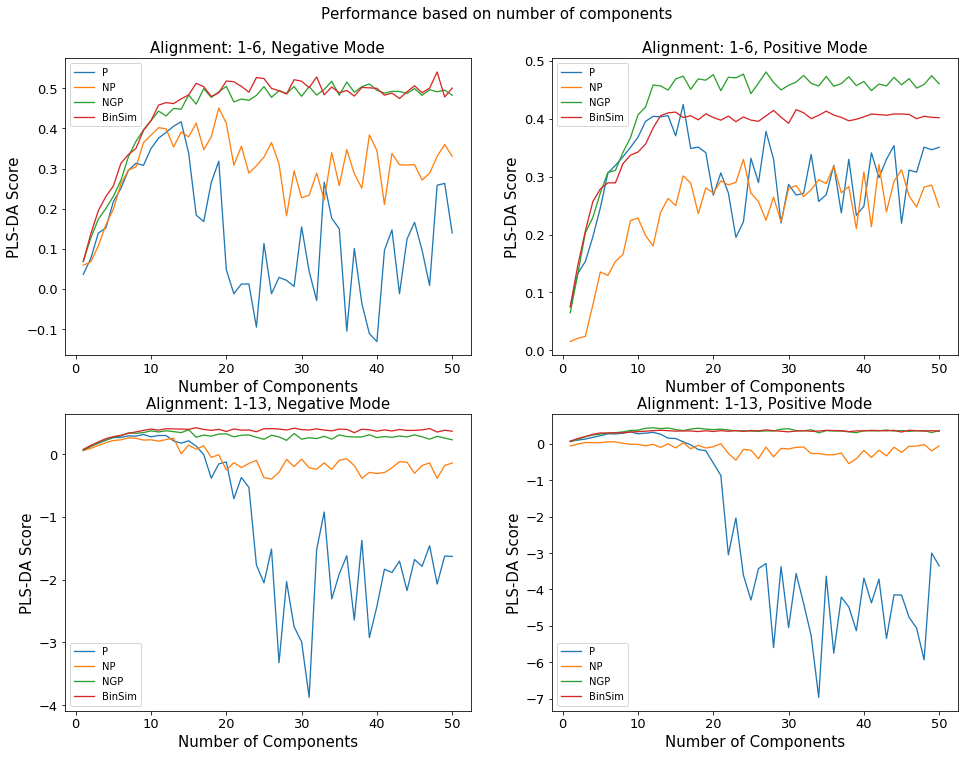

In [125]:
f, axes = plt.subplots(2, 2, figsize = (16,12))
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
plt.suptitle('Performance based on number of components', fontsize = 15, x = 0.5, y = 0.94)

for name, data in PLS_optim.items():
    if name.endswith('neg'):
        quadrant[0].plot(range(1,51),data)
        quadrant[0].set_xlabel('Number of Components', fontsize=15)
        quadrant[0].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[0].set_title('Alignment: 1-6, Negative Mode', fontsize=15)
        quadrant[0].tick_params(axis='both', which='major', labelsize=13)
        quadrant[0].legend(('P', 'NP', 'NGP', 'BinSim'))
    if name.endswith('pos'):
        quadrant[1].plot(range(1,51),data)
        quadrant[1].set_xlabel('Number of Components', fontsize=15)
        quadrant[1].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[1].set_title('Alignment: 1-6, Positive Mode', fontsize=15)
        quadrant[1].tick_params(axis='both', which='major', labelsize=13)
        quadrant[1].legend(('P', 'NP', 'NGP', 'BinSim'))
    if name.endswith('neg2'):
        quadrant[2].plot(range(1,51),data)
        quadrant[2].set_xlabel('Number of Components', fontsize=15)
        quadrant[2].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[2].set_title('Alignment: 1-13, Negative Mode', fontsize=15)
        quadrant[2].tick_params(axis='both', which='major', labelsize=13)
        quadrant[2].legend(('P', 'NP', 'NGP', 'BinSim'))
    if name.endswith('pos2'):
        quadrant[3].plot(range(1,51),data)
        quadrant[3].set_xlabel('Number of Components', fontsize=15)
        quadrant[3].set_ylabel('PLS-DA Score', fontsize=15)
        quadrant[3].set_title('Alignment: 1-13, Positive Mode', fontsize=15)
        quadrant[3].tick_params(axis='both', which='major', labelsize=13)
        quadrant[3].legend(('P', 'NP', 'NGP', 'BinSim'))

### Application of PLS-DA

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [126]:
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [127]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 15, iter_num = 100, feat_type = 'Coef')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for P_neg ...done
Fitting PLS-DA for NP_neg ...done
Fitting PLS-DA for NGP_neg ...done
Fitting PLS-DA for BinSim_neg ...done
Fitting PLS-DA for P_pos ...done
Fitting PLS-DA for NP_pos ...done
Fitting PLS-DA for NGP_pos ...done
Fitting PLS-DA for BinSim_pos ...done
Fitting PLS-DA for P_neg2 ...done
Fitting PLS-DA for NP_neg2 ...done
Fitting PLS-DA for NGP_neg2 ...done
Fitting PLS-DA for BinSim_neg2 ...done
Fitting PLS-DA for P_pos2 ...done
Fitting PLS-DA for NP_pos2 ...done
Fitting PLS-DA for NGP_pos2 ...done
Fitting PLS-DA for BinSim_pos2 ...done


### Alignment 1-6

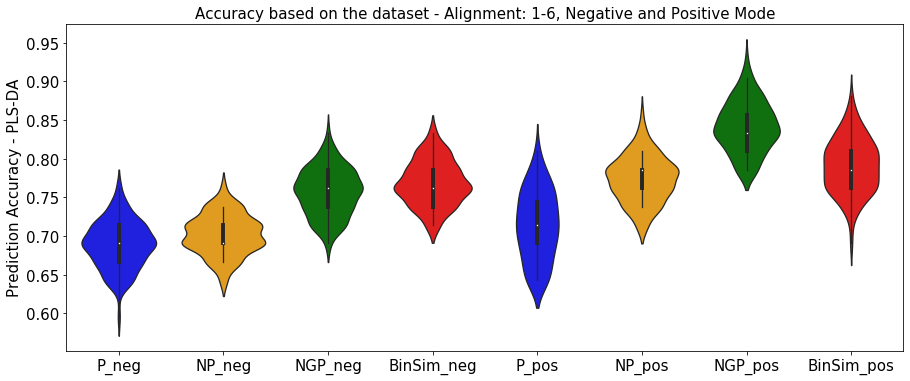

In [128]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,:8]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 1-6, Negative and Positive Mode', fontsize = 15)
plt.show()

### Alignment 1-13

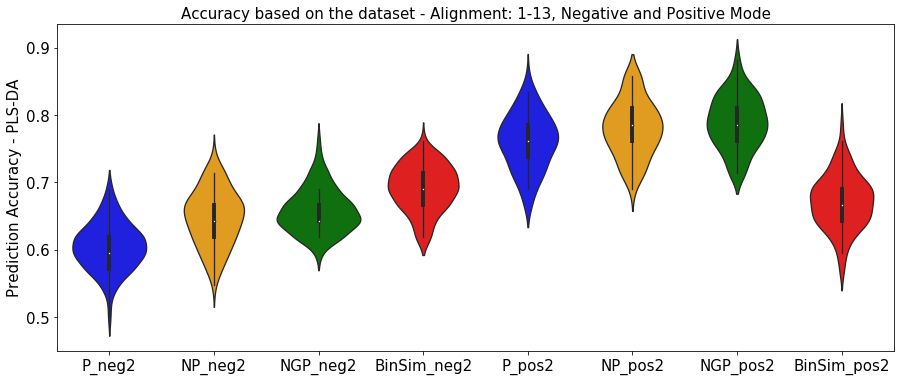

In [129]:
f, ax = plt.subplots(figsize=(15,6))
colors = ['blue','orange','green','red']
data=pd.DataFrame.from_dict(PLS_accu).iloc[:,8:]
sns.violinplot(data=data, palette = colors*2, alpha = 0.5)
plt.ylabel('Prediction Accuracy - PLS-DA', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize= 15)
plt.title('Accuracy based on the dataset - Alignment: 1-13, Negative and Positive Mode', fontsize = 15)
plt.show()

### Accuracies Summary

In [130]:
Accuracy = {}
Score = {}
Accuracy_std = {}
Score_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Score[name] = np.mean(PLS_score[name])
    
    Accuracy_std[name] = np.std(PLS_accu[name])
    Score_std[name] = np.std(PLS_score[name])

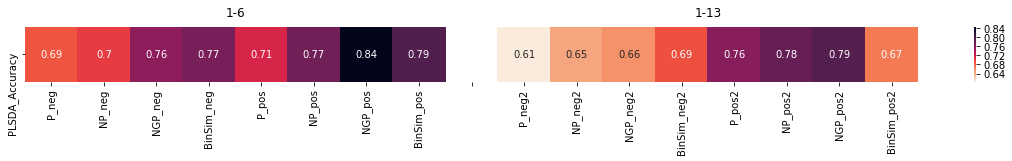

In [131]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T
#Inserting blank lines in the DataFrame for better presentation and separation
Accuracy_H = pd.concat([Accuracy_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Accuracy_H.iloc[:,8:]], axis = 1)

f, ax = plt.subplots(figsize=(20, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])

plt.text(4,-0.2,'1-6', fontsize  = 12, horizontalalignment='center')
plt.text(13,-0.2,'1-13', fontsize  = 12, horizontalalignment='center')
plt.show()

In [132]:
#Score_H = pd.DataFrame(list(Score.values()), index = Score.keys()).T
# Inserting blank lines in the DataFrame for better presentation and separation
#Score_H = pd.concat([Score_H.iloc[:,:8], pd.DataFrame(np.empty((1,1))* np.nan, index = ['']).T, Score_H.iloc[:,8:]], axis = 1)

#f, ax = plt.subplots(figsize=(20, 1))
#hm = sns.heatmap(Score_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Score'])

In [133]:
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys(), columns  = ['Accuracy']).iloc[:8].T
Accuracy_H.loc['SD'] = list(Accuracy_std.values())[:8]
Accuracy_H.T

Accuracy        SD
P_neg       0.689286  0.030187
NP_neg      0.702143  0.025532
NGP_neg     0.757381  0.030059
BinSim_neg  0.768810  0.028630
P_pos       0.714524  0.044352
NP_pos      0.774048  0.029642
NGP_pos     0.841905  0.032563
BinSim_pos  0.791429  0.035012

### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

Same process as applied for Random Forest.

In [134]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature 
ev = []
magni = []
index = []

for name in PLS_feat:
    if name.endswith('neg'):
        Spectra = aligned_all_neg
    elif name.endswith('pos'):
        Spectra = aligned_all_pos
    elif name.endswith('neg2'):
        Spectra = aligned_all_neg2
    elif name.endswith('pos2'):
        Spectra = aligned_all_pos2
    
    imp_features = PLS_feat[name]
    
    index.append(name)
    ratio = []
    nsamples = []
    n_groups = []
    
    # Top 2%
    number = round(0.02*len(Spectra))
    total_m = 0
    
    for i in range(len(imp_features)):
        total_m = total_m + imp_features[i][1]
    magni.append(imp_features[0][1]/(total_m/len(Spectra)))
    for i in range(number): 
        ngroups = {}
        line = Spectra.loc[imp_features[i][2],:].notnull()
        nsamples.append(line.sum())
        for n in range(len(line)):
            if line[n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        ratio.append(nsamples[-1]/n_groups[-1])
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [135]:
# Calculating averages of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []
for i in range(len(ev)):
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
df = pd.DataFrame(columns = ['samples_m', 'groups_m', 'ratio_m'], index = index)
df['samples_m'] = samples_m
df['groups_m'] = groups_m
df['ratio_m'] = ratio_m
#print(df)
# Inserting blank lines in the DataFrame for better presentation and separation
line = pd.DataFrame({"samples_m": None, "groups_m": None, 'ratio_m':None}, index=[''])
df = pd.concat([df.iloc[:4], line, df.iloc[4:8], line, df.iloc[8:12], line, df.iloc[12:]])

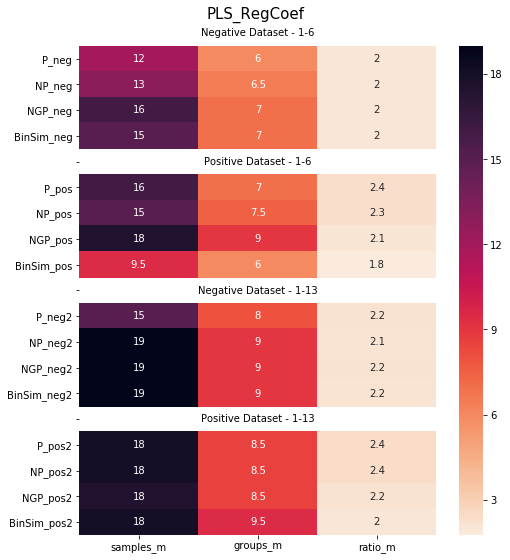

In [136]:
f, ax = plt.subplots(figsize=(8, 9))
hm = sns.heatmap(df, annot=True, ax=ax, cmap = sns.cm.rocket_r)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('PLS_RegCoef', fontsize = 15, x = 0.43, y = 0.94)
plt.text(1.5,-0.5,'Negative Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,4.5,'Positive Dataset - 1-6',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,9.5,'Negative Dataset - 1-13',horizontalalignment='center', verticalalignment='center')
plt.text(1.5,14.5,'Positive Dataset - 1-13',horizontalalignment='center', verticalalignment='center')
plt.show()

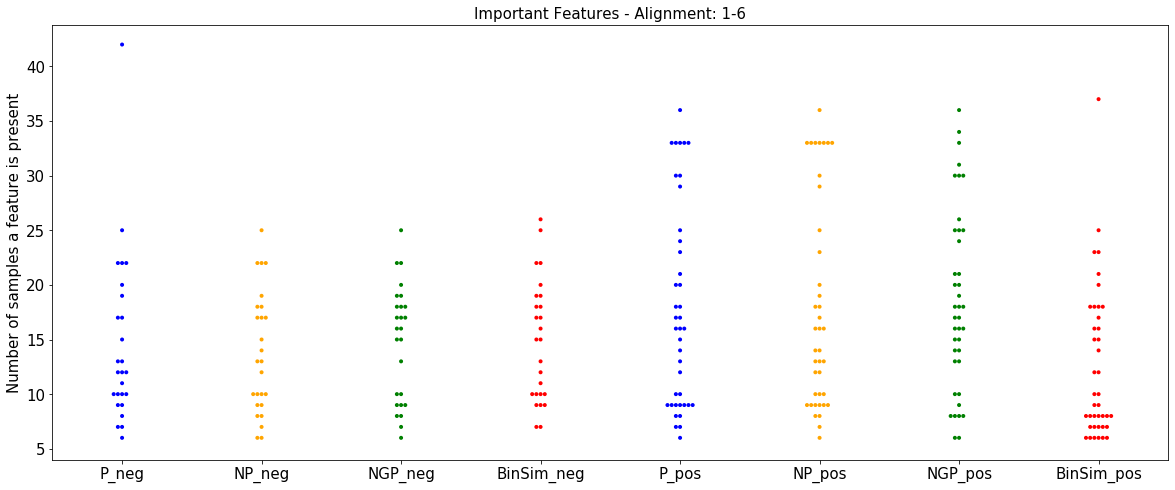

In [137]:
f, ax = plt.subplots(figsize=(20,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
#sns.violinplot(data=data)
sns.swarmplot(data=data[:8], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 1-6', fontsize = 15)
plt.show()

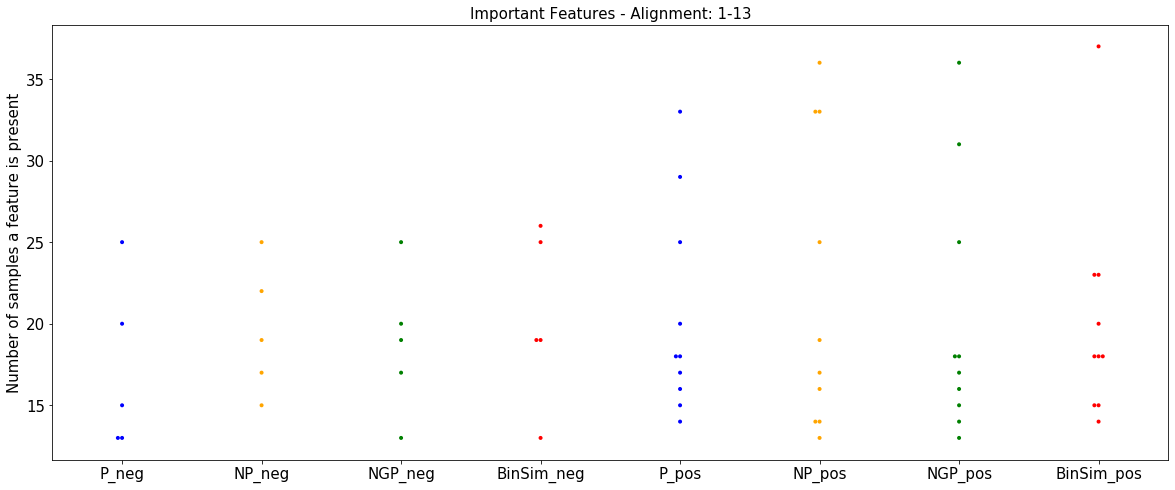

In [138]:
f, ax = plt.subplots(figsize=(20,8))
#sns.violinplot(data=data)
sns.swarmplot(data=data[8:], size = 4, palette = ['blue','orange','green','red']*2)
ax.set(xticklabels = [list(PLS_feat.keys())[i] for i in range(len(PLS_feat.keys()))])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.title('Important Features - Alignment: 1-13', fontsize = 15)
plt.show()

In [139]:
print('Magnitude of most important features for each case:')
for i in range(16):
    print(list(PLS_feat.keys())[i], '  \t', magni[i])

Magnitude of most important features for each case:
P_neg   	 9.516793908801349
NP_neg   	 12.22505010003228
NGP_neg   	 5.7667718813172
BinSim_neg   	 3.408763330393481
P_pos   	 16.03451806503313
NP_pos   	 7.051576493997837
NGP_pos   	 4.748988297272715
BinSim_pos   	 4.4906050192602285
P_neg2   	 3.710119377213043
NP_neg2   	 4.188265303044457
NGP_neg2   	 3.127840455561405
BinSim_neg2   	 2.3964039277808795
P_pos2   	 7.12196891399765
NP_pos2   	 3.9767789617610174
NGP_pos2   	 2.7720461923440753
BinSim_pos2   	 3.5356856066901057


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

In [140]:
def plot_PLSDA(principaldf, label_colors, components=(1,2), title="PLS-DA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        #ax.axis('equal')
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

#### NGP data treatment for the Negative Mode - Alignment: 1-6

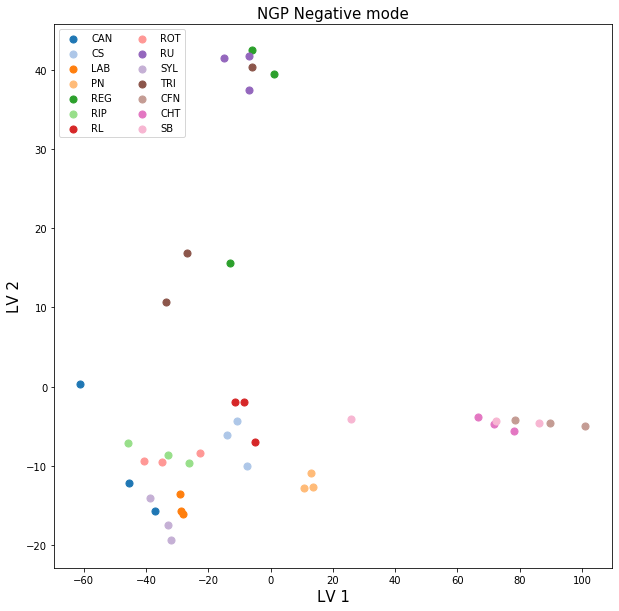

In [141]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim processed data for the negative mode - Alignment: 1-6

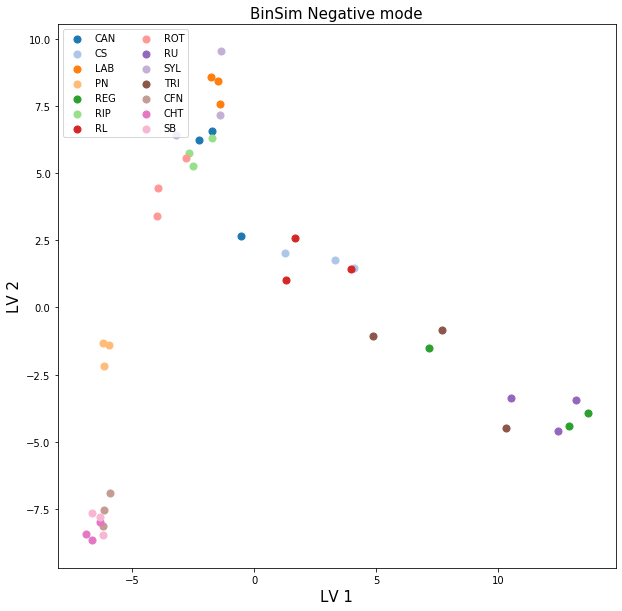

In [142]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(bin_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### NGP data treatment for the Negative Mode - Alignment: 1-13

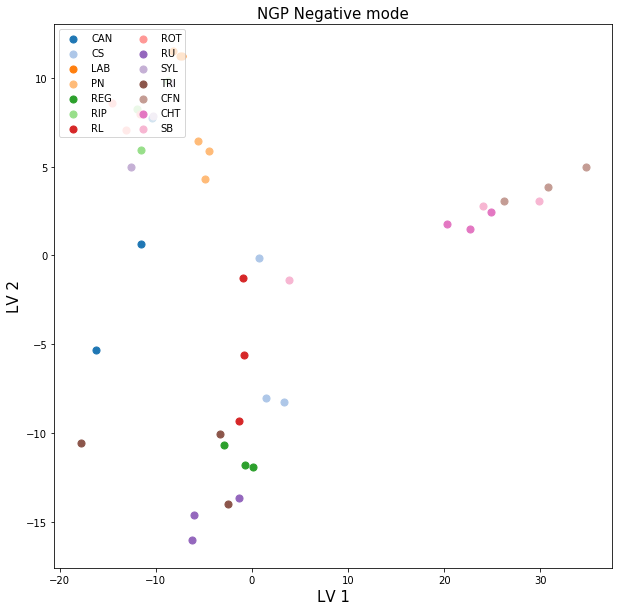

In [143]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(NGP_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="NGP Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

#### BinSim processed data for the negative mode - Alignment: 1-13

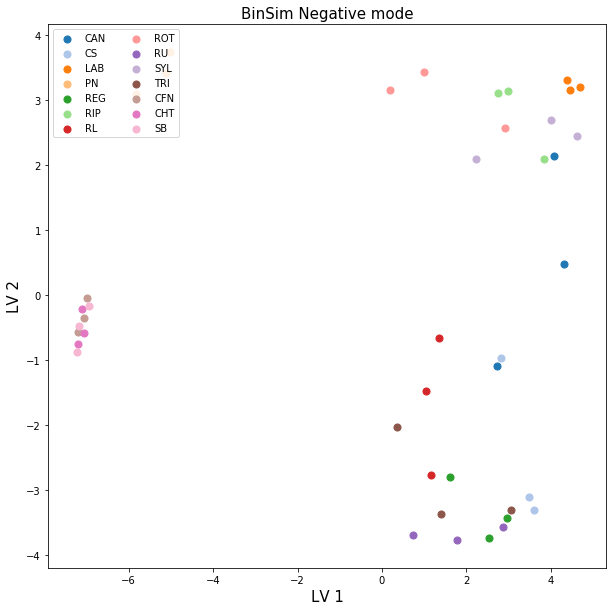

In [144]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(bin_neg2, n_components)

fig, axl = plt.subplots(1,1, figsize=(10,10))
plot_PLSDA(plsreg_GPneg, label_colors, title="BinSim Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.show()

## Permutation Tests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests (very slow)

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [145]:
CV = {}
PMs = {}
pvalue = {}

In [146]:
all_data = (P_neg, NP_neg, NGP_neg, bin_neg, P_pos, NP_pos, NGP_pos, bin_pos,
           P_neg2, NP_neg2, NGP_neg2, bin_neg2, P_pos2, NP_pos2, NGP_pos2, bin_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'BinSim_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'BinSim_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'BinSim_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'BinSim_pos2')

for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=150, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for P_neg ...
Done!
Permutation test (Random Forest) for NP_neg ...
Done!
Permutation test (Random Forest) for NGP_neg ...
Done!
Permutation test (Random Forest) for BinSim_neg ...
Done!
Permutation test (Random Forest) for P_pos ...
Done!
Permutation test (Random Forest) for NP_pos ...
Done!
Permutation test (Random Forest) for NGP_pos ...
Done!
Permutation test (Random Forest) for BinSim_pos ...
Done!
Permutation test (Random Forest) for P_neg2 ...
Done!
Permutation test (Random Forest) for NP_neg2 ...
Done!
Permutation test (Random Forest) for NGP_neg2 ...
Done!
Permutation test (Random Forest) for BinSim_neg2 ...
Done!
Permutation test (Random Forest) for P_pos2 ...
Done!
Permutation test (Random Forest) for NP_pos2 ...
Done!
Permutation test (Random Forest) for NGP_pos2 ...
Done!
Permutation test (Random Forest) for BinSim_pos2 ...
Done!


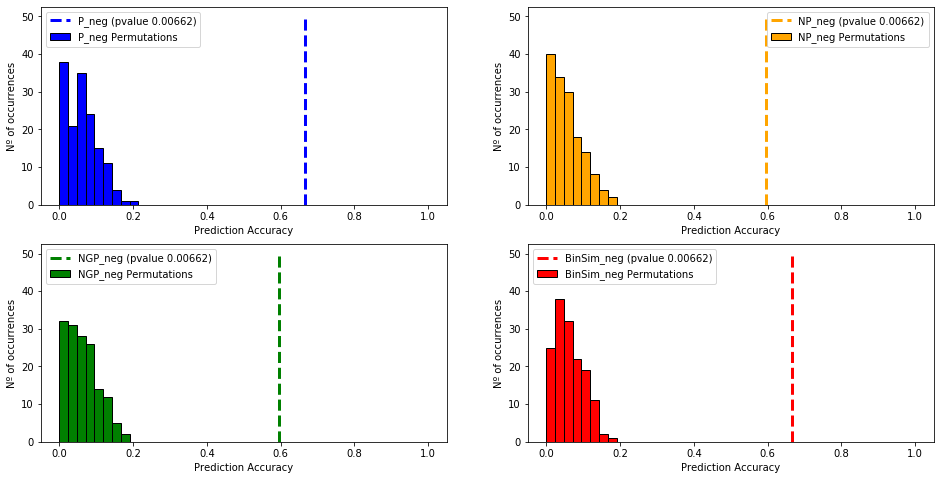

In [147]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'BinSim_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

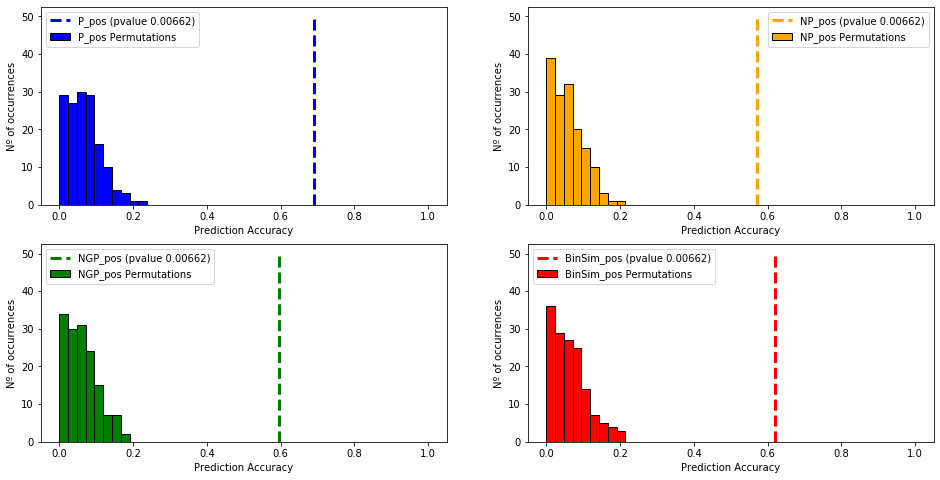

In [148]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'BinSim_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

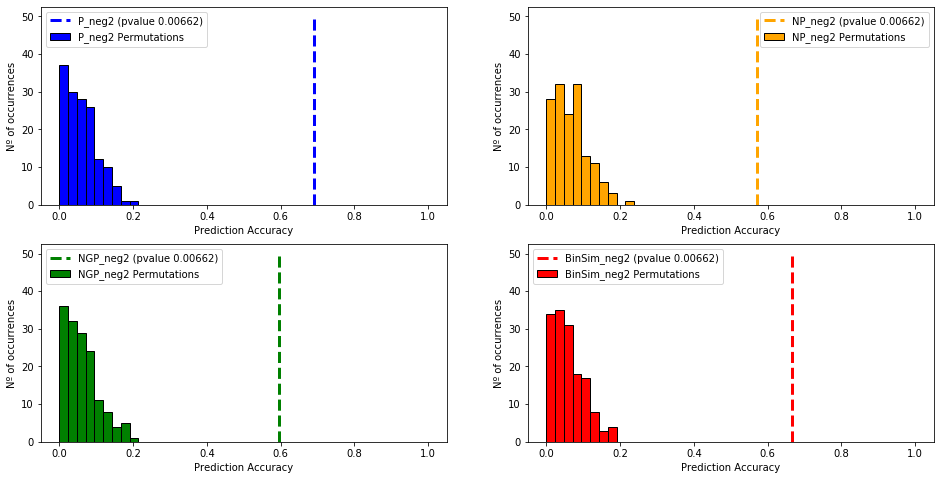

In [149]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'BinSim_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_neg2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

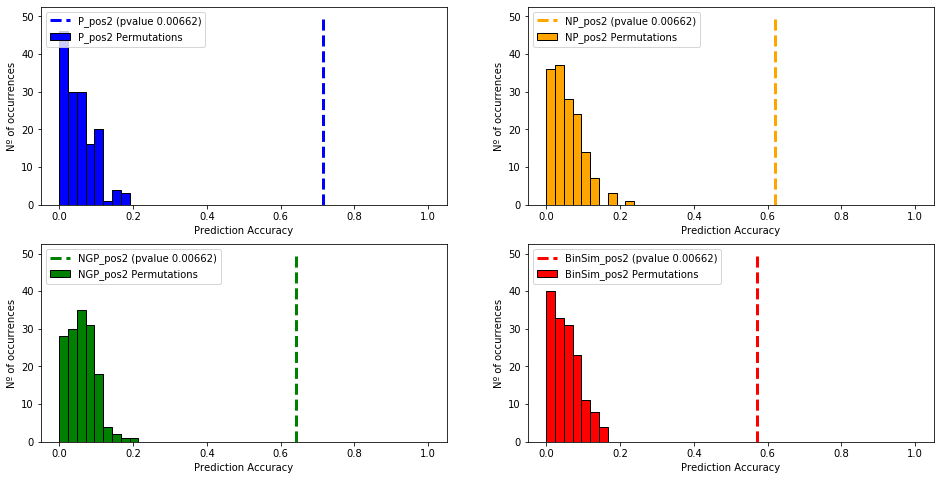

In [150]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'BinSim_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]
n_labels = len(NGP_pos2.cdl.labels)

#plt.suptitle('Permutation Tests - Random Forests')

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

### Permutation Tests - PLS-DA (slow)

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [151]:
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [152]:
all_data = (P_neg, NP_neg, NGP_neg, bin_neg, P_pos, NP_pos, NGP_pos, bin_pos,
           P_neg2, NP_neg2, NGP_neg2, bin_neg2, P_pos2, NP_pos2, NGP_pos2, bin_pos2)
names = ('P_neg', 'NP_neg', 'NGP_neg', 'BinSim_neg', 'P_pos', 'NP_pos', 'NGP_pos', 'BinSim_pos',
        'P_neg2', 'NP_neg2', 'NGP_neg2', 'BinSim_neg2', 'P_pos2', 'NP_pos2', 'NGP_pos2', 'BinSim_pos2')

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=15, iter_num=150)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for P_neg ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NP_neg ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP_neg ...
Done!
permutation test (PLS-DA) for BinSim_neg ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos ...
Done!
permutation test (PLS-DA) for NP_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for NGP_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for BinSim_pos ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_neg2 ...
Done!
permutation test (PLS-DA) for NP_neg2 ...
Done!
permutation test (PLS-DA) for NGP_neg2 ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for BinSim_neg2 ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for P_pos2 ...
Done!
permutation test (PLS-DA) for NP_pos2 ...
Done!
permutation test (PLS-DA) for NGP_pos2 ...
Done!
permutation test (PLS-DA) for BinSim_pos2 ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!


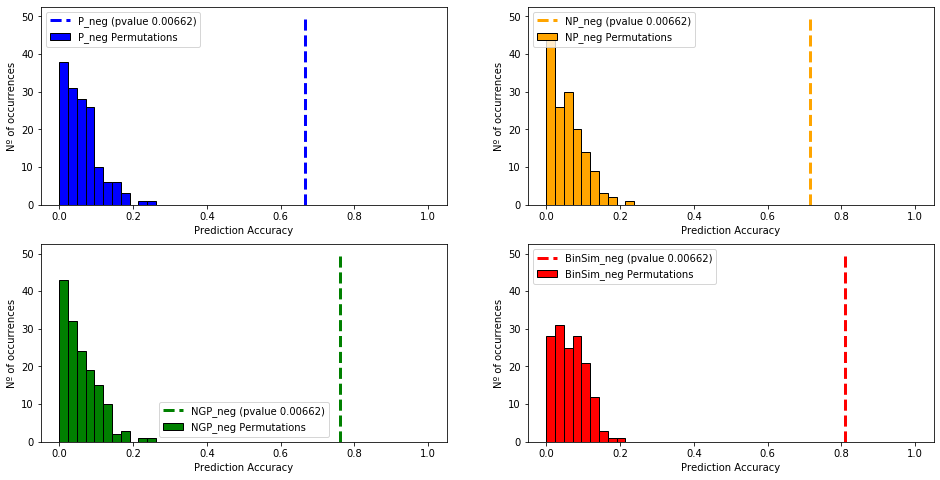

In [153]:
f, axes = plt.subplots(2, 2, figsize = (16,8))

Names = ['P_neg', 'NP_neg', 'NGP_neg', 'BinSim_neg']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

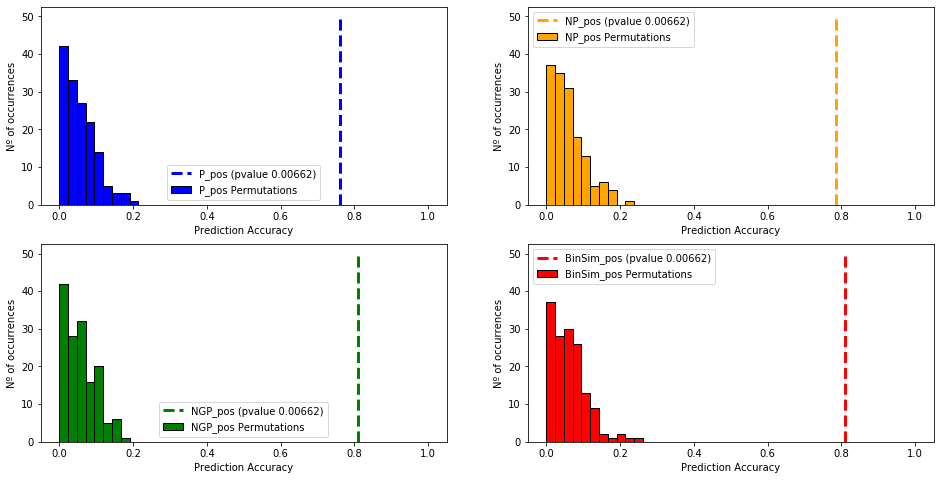

In [154]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos', 'NP_pos', 'NGP_pos', 'BinSim_pos']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

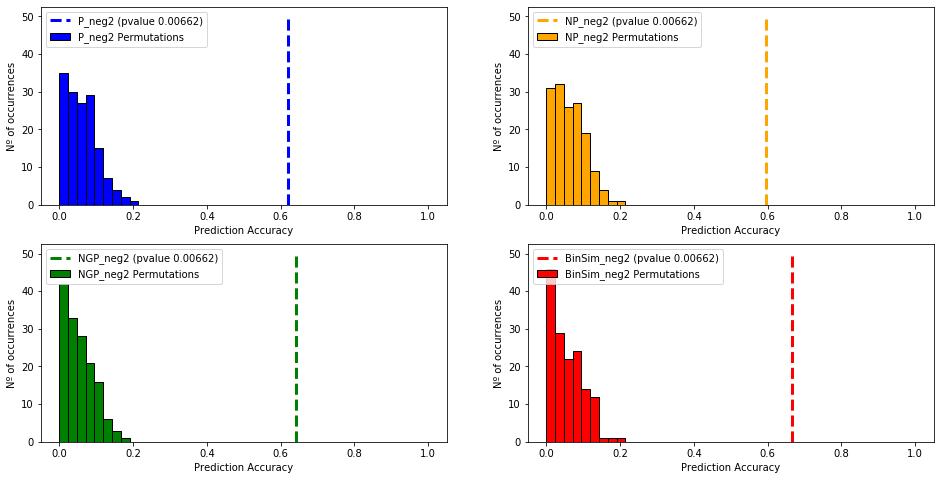

In [155]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_neg2', 'NP_neg2', 'NGP_neg2', 'BinSim_neg2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_neg2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()

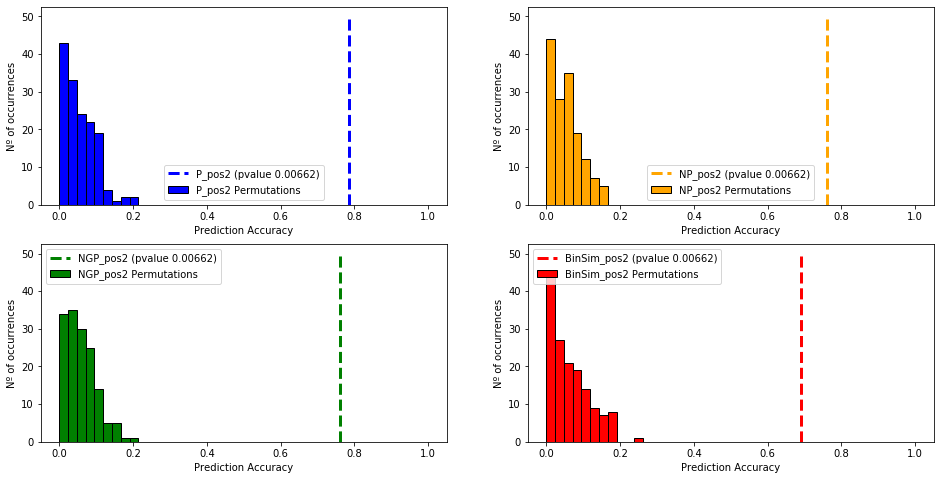

In [156]:
f, axes = plt.subplots(2, 2, figsize = (16,8))
#fig, axes = plt.subplots(1, 2)
Names = ['P_pos2', 'NP_pos2', 'NGP_pos2', 'BinSim_pos2']
color = ['blue', 'orange', 'green', 'red']
quadrant = [axes[0][0], axes[0][1], axes[1][0], axes[1][1]]
ylim = [0,50]

n_labels = len(NGP_pos2.cdl.labels)

for q, name, color in zip(quadrant, Names, colors):
    q.hist(PMs_PLS[name], n_labels, range=(0, 1.0001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]], ylim, '--g', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name])
    q.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
    q.legend()